# Exploratory Data Analysis

In [43]:
from sqlalchemy import create_engine, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import pandas as pd

# Database configuration
DB_USERNAME = 'postgres'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'
DB_PORT = '5432'  # Default port for PostgreSQL
DB_NAME = 'brazilian_ecommerce_db'

In [ ]:


# Database configuration
DB_USERNAME = 'your_username'     # Replace with your PostgreSQL username
DB_PASSWORD = 'your_password'     # Replace with your PostgreSQL password
DB_HOST = 'localhost'             # Database host
DB_PORT = '5432'                  # Default port for PostgreSQL
DB_NAME = 'your_database_name'    # Database name to use or create for the project



In [44]:
# Create an engine to connect to PostgreSQL
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# filter the orders to include only data from the entire year of 2017 and up to August in 2018 
# BECAUSE THERE IS NO DATA AFTER AUGUST 2018 and a very small data about 2016

orders_by = pd.read_sql("""
    SELECT
        o.order_purchase_timestamp,
        INITCAP(c.customer_city) AS city,
        c.customer_state AS state
    FROM orders AS o
    JOIN customers AS c 
    ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
        AND (
            EXTRACT(YEAR FROM o.order_purchase_timestamp) = 2017
            OR (EXTRACT(YEAR FROM o.order_purchase_timestamp) = 2018 
                AND EXTRACT(MONTH FROM o.order_purchase_timestamp) <= 8)
        );
""", engine)

engine.dispose()

In [45]:
# Таблица заказов (olist_orders_dataset)
# Изучи даты создания заказов и их статус. Построй график, показывающий количество заказов по месяцам и дням недели,
# чтобы выявить сезонные или недельные тренды.
# Посмотри, как распределяются статусы заказов (например, завершённые, отменённые, отправленные).
# Таблица платежей (olist_order_payments_dataset):
import pandas as pd

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
                                 
orders_by['month'] = orders_by['order_purchase_timestamp'].dt.month_name()
orders_by['season'] = orders_by['order_purchase_timestamp'].dt.month.apply(get_season)
orders_by['day'] = orders_by['order_purchase_timestamp'].dt.day_name()
orders_by['year'] = orders_by['order_purchase_timestamp'].dt.year

# Define custom order for month names
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
# Define custom order for seasons
season_order = [ 'Winter','Spring', 'Summer', 'Autumn']

# Define custom order for weekdays
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]

# Convert the columns to categorical type with defined order
orders_by['month'] = pd.Categorical(orders_by['month'], categories=month_order, ordered=True)
orders_by['season'] = pd.Categorical(orders_by['season'], categories=season_order, ordered=True)
orders_by['day'] = pd.Categorical(orders_by['day'], categories=weekday_order, ordered=True)
orders_by['state'] = orders_by['state'].astype('category')
orders_by['city'] = orders_by['city'].astype('category')
orders_by.drop('order_purchase_timestamp', axis = 1, inplace = True)

In [46]:
orders_by.head()

,city,state,month,season,day,year
0,Belo Horizonte,MG,December,Winter,Tuesday,2017
1,Jundiai,SP,September,Autumn,Monday,2017
2,Cachoeiro De Itapemirim,ES,September,Autumn,Friday,2017
3,Cacapava,SP,July,Summer,Monday,2018
4,Sao Vicente,SP,March,Spring,Wednesday,2018


In [47]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

orders_amount = pd.read_sql("""
    SELECT
        p.payment_value,
        o.order_purchase_timestamp,
        INITCAP(c.customer_city) AS city,
        c.customer_state AS state
    FROM orders AS o
    JOIN payments AS p ON o.order_id = p.order_id
    JOIN customers AS c ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered';
""", engine)
engine.dispose()

orders_amount['month'] = orders_amount['order_purchase_timestamp'].dt.month_name()
orders_amount['season'] = orders_amount['order_purchase_timestamp'].dt.month.apply(get_season)
orders_amount['day'] = orders_amount['order_purchase_timestamp'].dt.day_name()
orders_amount['year'] = orders_amount['order_purchase_timestamp'].dt.year

# Convert the columns to categorical type with defined order
orders_amount['month'] = pd.Categorical(orders_amount['month'], categories=month_order, ordered=True)
orders_amount['season'] = pd.Categorical(orders_amount['season'], categories=season_order, ordered=True)
orders_amount['day'] = pd.Categorical(orders_amount['day'], categories=weekday_order, ordered=True)
orders_amount['state'] = orders_amount['state'].astype('category')
orders_amount['city'] = orders_amount['city'].astype('category')
orders_amount.drop('order_purchase_timestamp', axis = 1, inplace = True)

In [48]:
orders_amount.head()

,payment_value,city,state,month,season,day,year
0,99.33,Teofilo Otoni,MG,April,Spring,Wednesday,2018
1,24.39,Sao Paulo,SP,June,Summer,Tuesday,2018
2,65.71,Sao Paulo,SP,December,Winter,Tuesday,2017
3,107.78,Juiz De Fora,MG,December,Winter,Wednesday,2017
4,128.45,Conchas,SP,May,Spring,Monday,2018


### Analysis about Sales Counts

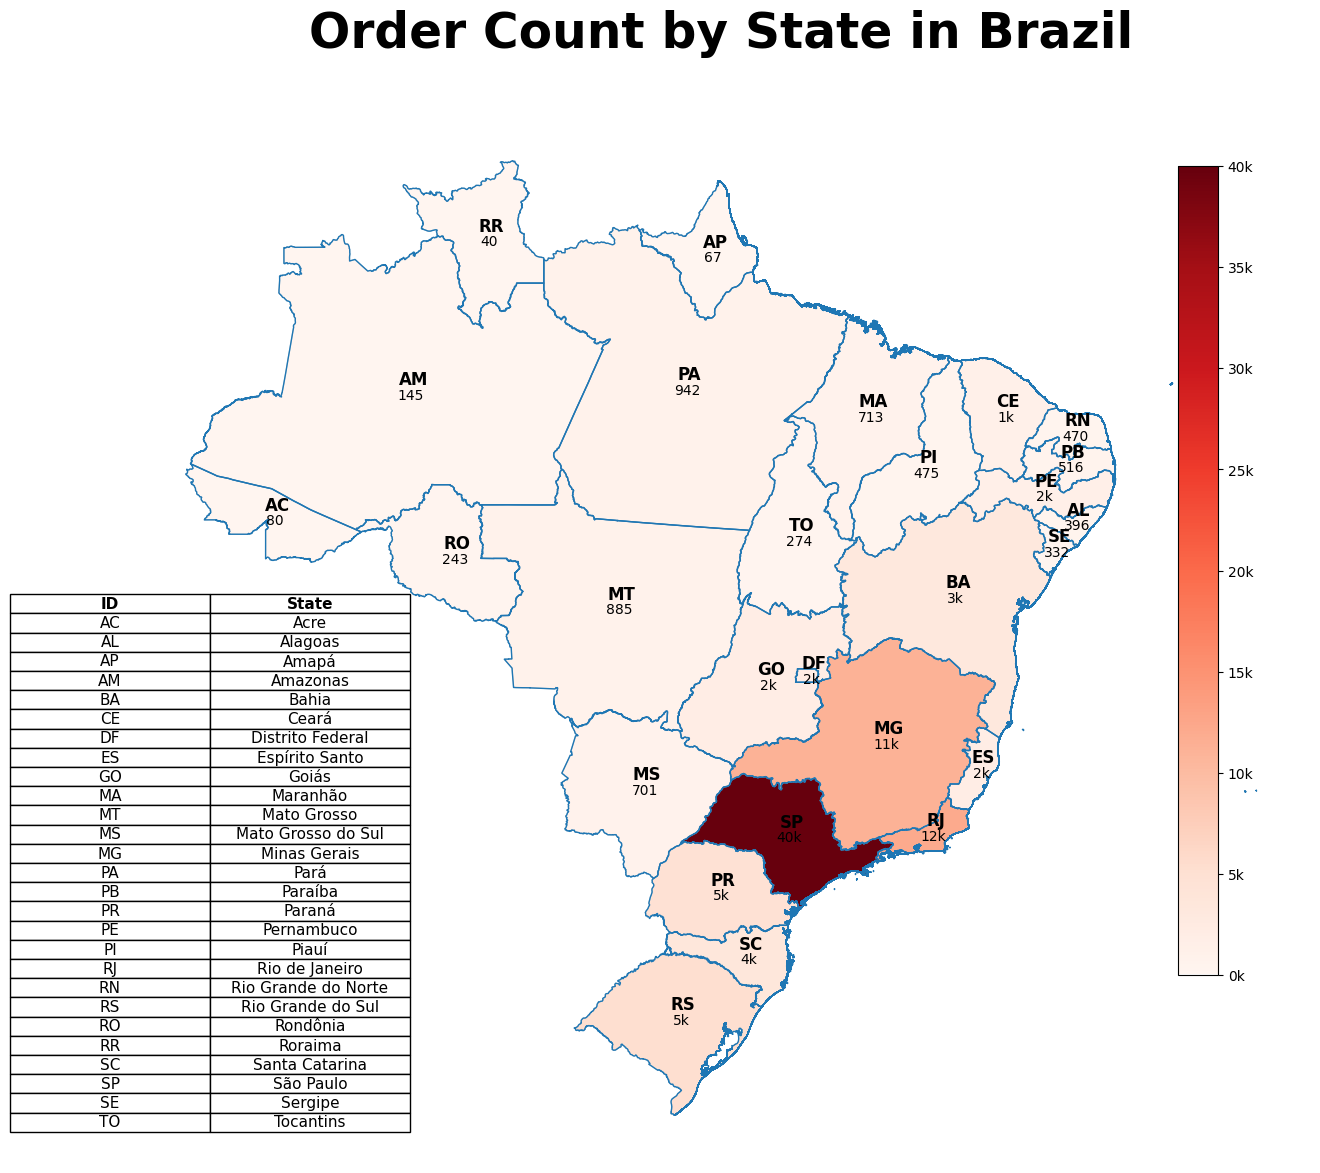

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

# Load the GeoJSON file for Brazil's states
brazil_geo = gpd.read_file("brazil_geo.json")

# Group orders by state and count
orders_by_state = orders_by.groupby('state', observed=False).size().reset_index(name='order_count')

# Create a mapping from state abbreviations to full names
state_mapping = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AM': 'Amazonas', 'AP': 'Amapá',
    'BA': 'Bahia', 'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo',
    'GO': 'Goiás', 'MA': 'Maranhão', 'MG': 'Minas Gerais', 'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso', 'PA': 'Pará', 'PB': 'Paraíba', 'PE': 'Pernambuco',
    'PI': 'Piauí', 'PR': 'Paraná', 'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte',
    'RO': 'Rondônia', 'RR': 'Roraima', 'RS': 'Rio Grande do Sul',
    'SC': 'Santa Catarina', 'SE': 'Sergipe', 'SP': 'São Paulo', 'TO': 'Tocantins'
}

# Map the state abbreviations to full names
orders_by_state['state'] = orders_by_state['state'].map(state_mapping)

# Function to format the order count
def format_count(x):
    if pd.isnull(x):
        return "0"
    if x >= 1000000:
        return f'{x / 1000000:,.1f}M'
    elif x >= 1000:
        return f'{x / 1_000:,.0f}k'
    else:
        return f'{x:,.0f}'
    return f"{int(x):,}"  # Format with commas for better readability

# Create a new column for formatted counts in the orders_by_state DataFrame
orders_by_state['formatted_count'] = orders_by_state['order_count'].apply(format_count)

# Merge GeoDataFrame with order data
brazil_map = brazil_geo.merge(orders_by_state, left_on='name', right_on='state', how='left')

# Plot the map with color coding based on order counts
fig, ax = plt.subplots(1, 1, figsize=(20, 15))  # Increased figure size
brazil_map.boundary.plot(ax=ax, linewidth=1)

# Use a continuous color map from white to red
plot = brazil_map.plot(
    column="order_count", cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8"
)

# Add the color bar manually
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=brazil_map["order_count"].min(), vmax=brazil_map["order_count"].max() // 1000 * 1000))
sm._A = []  # Empty array for the ScalarMappable
colorbar = fig.colorbar(sm, ax=ax, shrink=0.7)

# Format color bar to show values in "k" (thousands)
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([f"{int(tick/1000)}k" for tick in colorbar.get_ticks()])

# Adjust the position of the axis
ax.set_position([0.1, 0.1, 0.75, 0.7])  # [left, bottom, width, height]

# Add formatted count as text annotations on each state
for _, row in brazil_map.iterrows():
    # Position for formatted order count
    plt.text(
        row.geometry.centroid.x + 0.2,
        row.geometry.centroid.y - 0.3,
        row['formatted_count'],
        ha="center",
        fontsize=10,
        color="black"
    )
    
    # Position for state names
    plt.text(
        row.geometry.centroid.x + 0.3,
        row.geometry.centroid.y + 0.3,
        row['id'],
        ha="center",
        fontsize=12,
        color="black",
        fontweight='bold'
    )

# Create a table with order counts on the right side
table_data = orders_by_state[['state', 'formatted_count']]
table_data.columns = ['State', '']

# Hide axes
ax.axis("off") 

# Create a new axes for the table with adjusted size
table_ax = fig.add_axes([0.2, 0.1, 0.2, 0.4])  # Position of the table [left, bottom, width, height]
table_ax.axis('tight')
table_ax.axis('off')

table_data = brazil_map[['id', 'name']]
table_data.columns = ['ID', 'State']

# Create the table with increased height
table = table_ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Format table cell text size and height
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(12)  # Adjust font size
    cell.set_edgecolor('black')  # Add border
    # Increase the height of the rows
    cell.set_height(0.032)  # Adjust this value as needed to increase row height

    # Make the first row bold (header row)
    if i == 0:  # Check if it's the header row
        cell.set_text_props(fontweight='bold')
    else:
        if j == 0:  # ID column (only for non-header rows)
            cell.set_text_props(fontweight='normal')  # Regular weight for ID
        if j == 1:  # State column (only for non-header rows)
            cell.set_text_props(fontweight='normal')  # Regular weight for state

ax.set_title("Order Count by State in Brazil\n", fontsize=35, fontweight='bold')  # Increased title font size
plt.show()


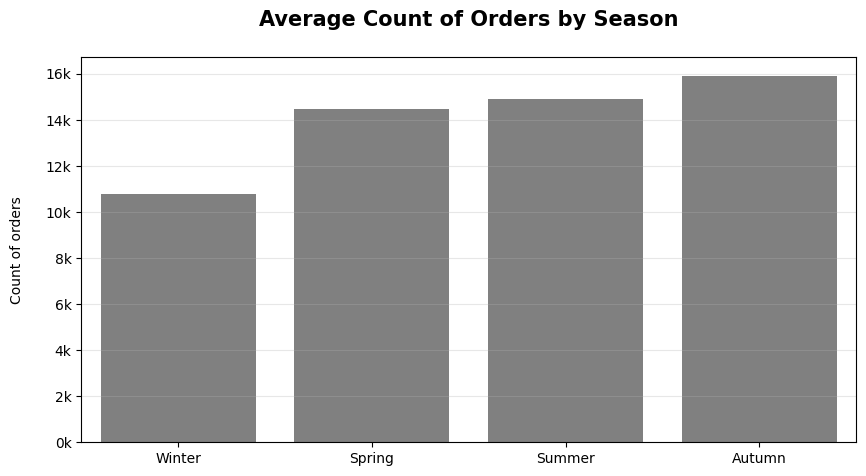

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total order count and number of available years for each season
season_counts = orders_by.groupby(['season', 'year'], observed=False).size().reset_index(name='order_count')
season_avg_counts = season_counts.iloc[:7].groupby('season', observed=False).agg(avg_order_count=('order_count', 'mean')).reset_index()

# Plot the average order count by season
plt.figure(figsize=(10, 5))
sns.barplot(x='season', y='avg_order_count', data=season_avg_counts,
            order=orders_by['season'].cat.categories, color='grey')
plt.title('Average Count of Orders by Season\n', fontsize=15, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.grid(visible=True, axis='y', alpha=0.3)
plt.show()

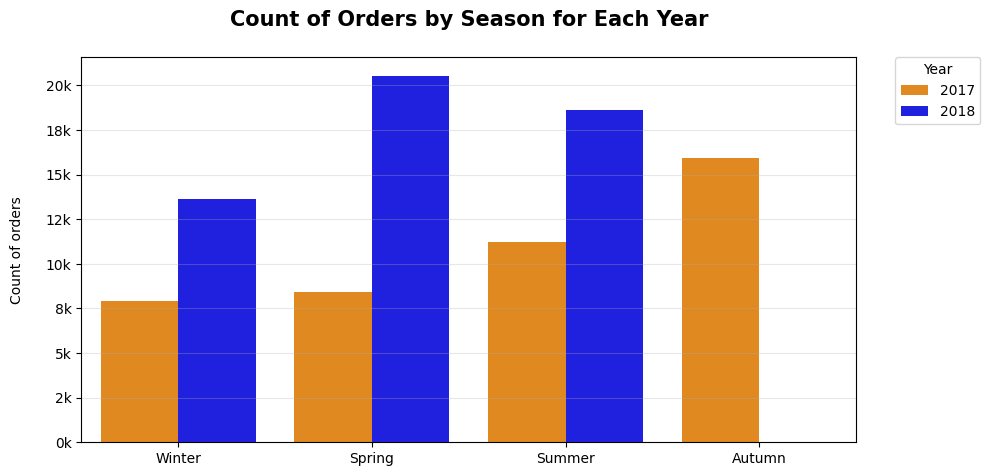

In [51]:
plt.figure(figsize=(10, 5))
sns.countplot(x='season', data=orders_by, hue='year', 
              order=orders_by['season'].cat.categories, palette=['darkorange','blue'])
plt.title('Count of Orders by Season for Each Year\n', fontsize=15, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(visible = True, axis = 'y', alpha = 0.3)
plt.show()

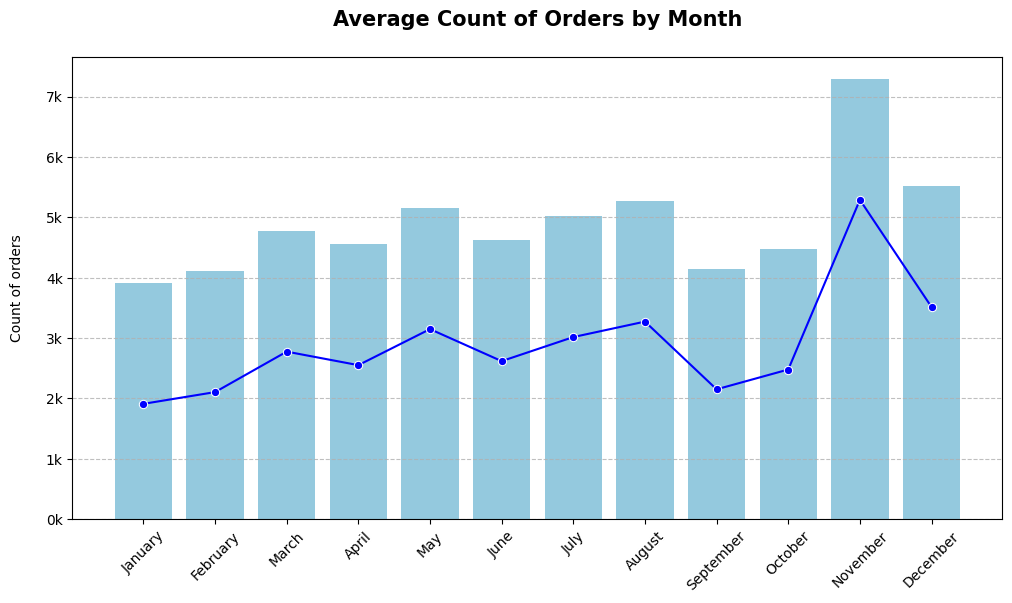

In [52]:
month_counts = orders_by.groupby(['month', 'year'], observed = False).size().reset_index(name='order_count')
month_counts = month_counts[~((month_counts["year"] == 2018) & 
                              (month_counts["month"].isin(['September', 'October', 'November', 'December'])))]
month_avg_counts = month_counts.groupby('month', observed = False).agg(avg_order_count=('order_count', 'mean')).reset_index()

plt.figure(figsize=(12, 6))
# Bar plot for average order count by month
sns.barplot(x='month', y='avg_order_count', data=month_avg_counts, 
            order=month_order, color='skyblue')
# Line plot overlay for the trend of average order count by month
sns.lineplot(x='month', y=month_avg_counts['avg_order_count'] - 2000, data=month_avg_counts, 
             marker='o', color='blue')

# Formatting the plot
plt.title('Average Count of Orders by Month\n', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.grid(visible=True, axis='y', alpha=0.8, linestyle="--")
plt.show()

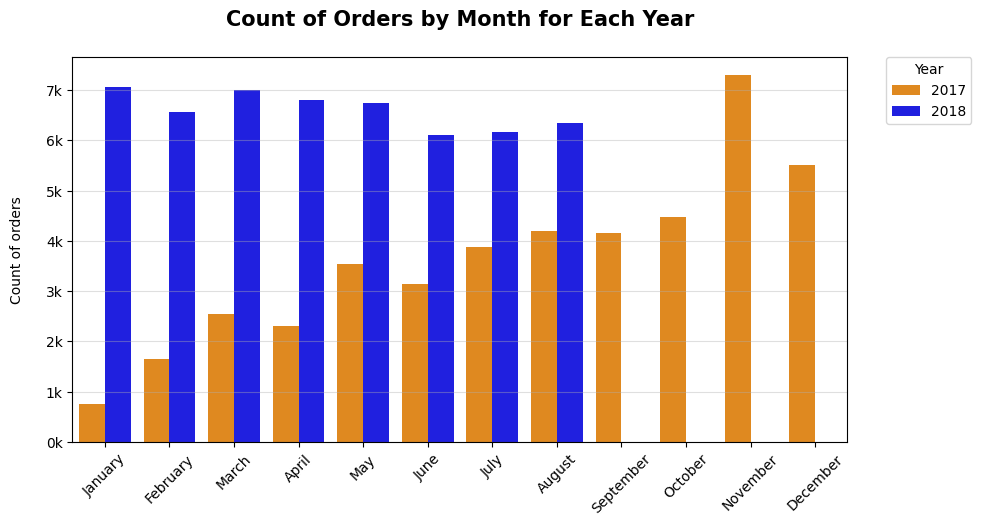

In [53]:
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=orders_by, hue='year', 
              order=orders_by['month'].cat.categories, palette=['darkorange','blue'])
plt.title('Count of Orders by Month for Each Year\n', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(visible = True, axis = 'y', alpha = 0.4)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_4948\467598077.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_counts = orders_by.groupby(['month', 'year']).size().reset_index(name='order_count')


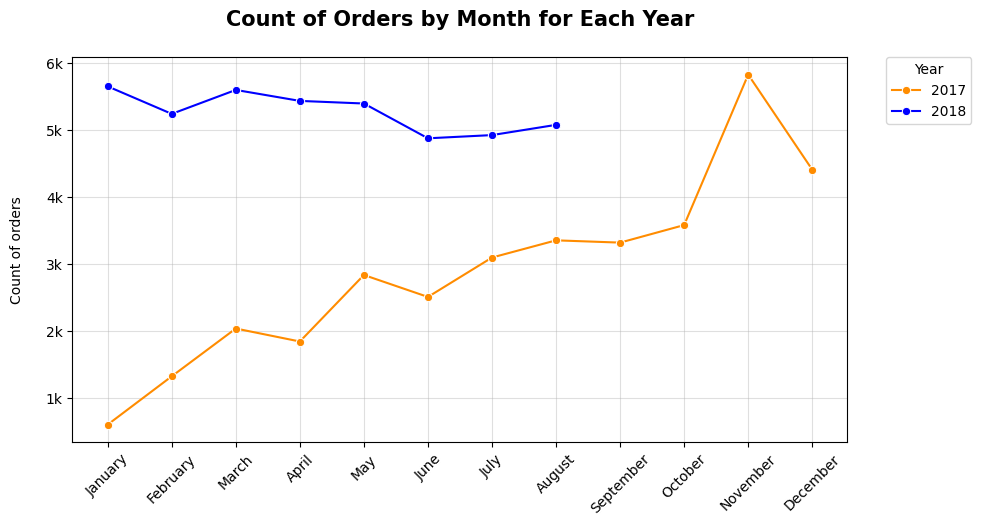

In [54]:
plt.figure(figsize=(10, 5))
order_counts = orders_by.groupby(['month', 'year']).size().reset_index(name='order_count')
order_counts = order_counts[(order_counts['year'] == 2017) | 
                            ((order_counts['year'] == 2018) & 
                             (order_counts['month'].isin(['January', 'February', 'March', 'April', 
                                                           'May', 'June', 'July', 'August'])))]
sns.lineplot(x='month', y=order_counts['order_count'] * 4 // 5, hue='year', data=order_counts, 
             hue_order=sorted(order_counts['year'].unique()), palette=['darkorange','blue'], marker='o')

plt.title('Count of Orders by Month for Each Year\n', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(visible = True, alpha = 0.4)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_4948\3024829945.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = orders_by.groupby(['year', 'month']).size().reindex(
C:\Users\Acer\AppData\Local\Temp\ipykernel_4948\3024829945.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['month_comparison'] = yearly_data['month'] + ' - ' + yearly_data['month'].shift(1)


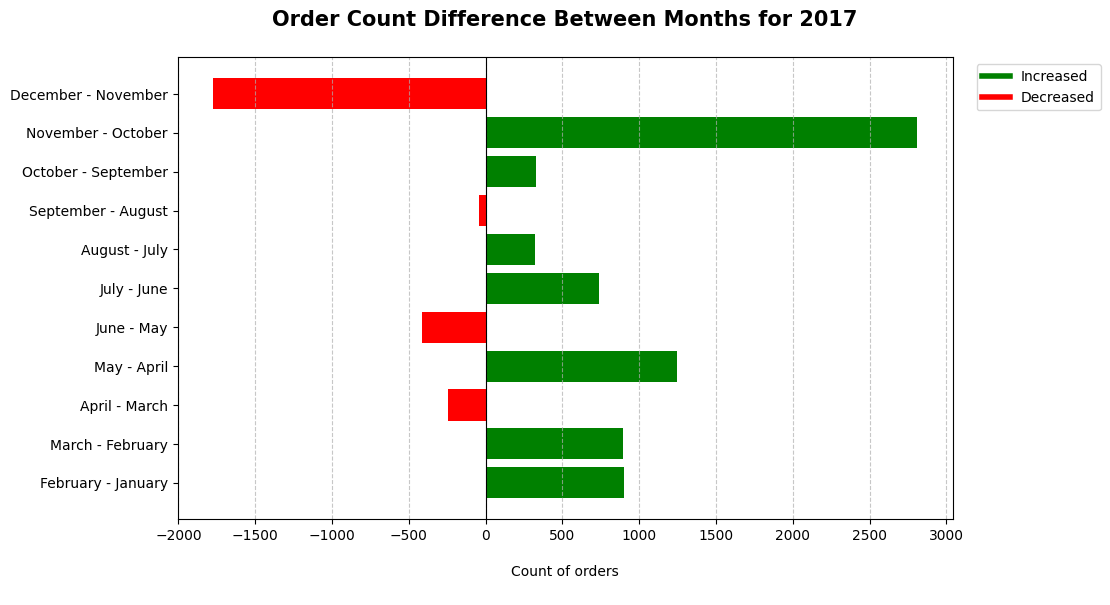

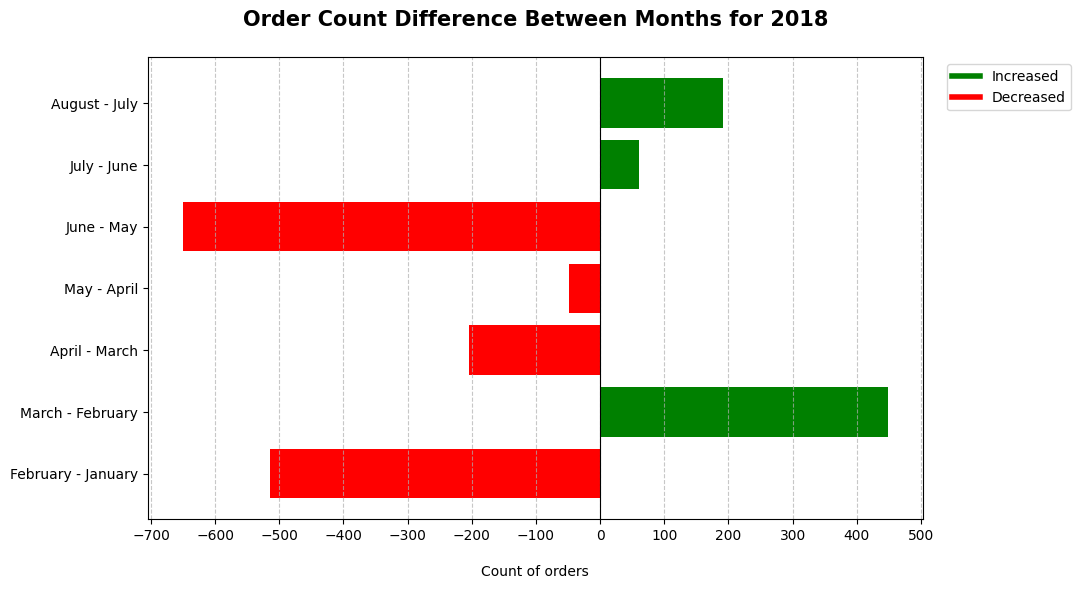

In [55]:
# Group by month and year, then count orders
monthly_counts = orders_by.groupby(['year', 'month']).size().reindex(
    pd.MultiIndex.from_product([orders_by['year'].unique(), month_order], names=['year', 'month']),
    fill_value=0
).reset_index(name='count')

# Calculate the difference between consecutive months
monthly_counts['difference'] = monthly_counts.groupby('year')['count'].diff().fillna(0)

# Create a new column for month comparisons
monthly_counts['month_comparison'] = monthly_counts['month'].shift(1).combine_first(monthly_counts['month'])

# Create plots for each year
for year in monthly_counts['year'].unique():
    yearly_data = monthly_counts[monthly_counts['year'] == year]

    # Exclude specified months
    if year == 2018:
        yearly_data = yearly_data[~yearly_data['month'].isin(['September', 'October', 'November', 'December'])]

    # Update month_comparison to reflect the new format
    yearly_data['month_comparison'] = yearly_data['month'] + ' - ' + yearly_data['month'].shift(1)

    plt.figure(figsize=(10, 6))
    plt.barh(yearly_data['month_comparison'].iloc[1:], yearly_data['difference'].iloc[1:], 
             color=(yearly_data['difference'].iloc[1:] > 0).map({True: 'green', False: 'red'}))

    plt.axvline(0, color='black', linewidth=0.8)  # Add vertical line at x=0
    plt.title(f'Order Count Difference Between Months for {year}\n', fontsize=15, fontweight='bold')
    plt.xlabel('\nCount of orders\n')
    plt.ylabel('')

    if year == 2018:
        min_x = np.floor(yearly_data['difference'].min() / 100) * 100
        max_x = np.ceil(yearly_data['difference'].max() / 100) * 100
    else:
        min_x = np.floor(yearly_data['difference'].min() / 500) * 500
        max_x = np.ceil(yearly_data['difference'].max() / 500) * 500

    # Set x-axis ticks based on the year
    step = 500 if year == 2017 else 100
    plt.xticks(range(int(min_x), int(max_x) + step, step))

    plt.grid(axis='x', linestyle='--', alpha=0.7)
    handles = [plt.Line2D([0], [0], color='green', lw=4, label='Increased'),
               plt.Line2D([0], [0], color='red', lw=4, label='Decreased')]
    plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.2, 1))
    
    plt.show()

In [56]:
weekly_counts = orders_by.groupby(['day', 'year'],observed = False).size().reset_index(name='order_count')

date_range_2017 = pd.date_range(start='2017-01-01', end='2017-12-31')
date_range_2018 = pd.date_range(start='2018-01-01', end='2018-09-30')

# Function to create a table for the given date range
def create_weekday_count_table(date_range):
    df = pd.DataFrame(date_range, columns=['date'])
    df['day'] = df['date'].dt.day_name()  # Get the weekday names
    df['year'] = df['date'].dt.year       # Extract the year
    
    # Count the occurrences of each weekday
    weekday_counts = df.groupby(['day', 'year']).size().reset_index(name='count_of_weekday')
    
    return weekday_counts

# Create tables for both years
table_2017 = create_weekday_count_table(date_range_2017)
table_2018 = create_weekday_count_table(date_range_2018)
combined_table = pd.concat([table_2017, table_2018], ignore_index=True)
weekly_counts = combined_table.merge(weekly_counts, on=['day', 'year'], how='inner')
weekly_counts["avg_order_count"] = weekly_counts["order_count"] / weekly_counts["count_of_weekday"]
weekly_counts["day"] = pd.Categorical(weekly_counts["day"], categories=weekday_order, ordered=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_4948\2673691772.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_orders_by_day = weekly_counts.groupby('day', as_index=False).agg({'avg_order_count': 'mean'})


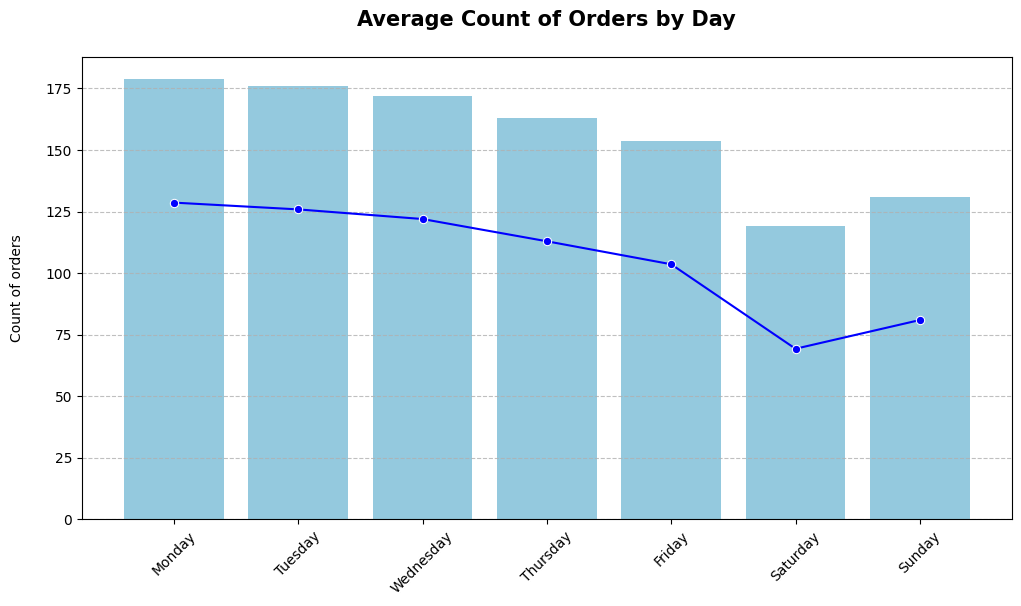

In [57]:
average_orders_by_day = weekly_counts.groupby('day', as_index=False).agg({'avg_order_count': 'mean'})
average_orders_by_day["day"] = pd.Categorical(average_orders_by_day['day'], categories=weekday_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='day', y='avg_order_count', data=average_orders_by_day, 
             color='skyblue')
sns.lineplot(x='day', y=average_orders_by_day['avg_order_count'] - 50, data=average_orders_by_day,
             marker='o', color='blue')
# Formatting the plot
plt.title('Average Count of Orders by Day\n', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.grid(visible=True, axis='y', alpha=0.8, linestyle="--")
plt.show()

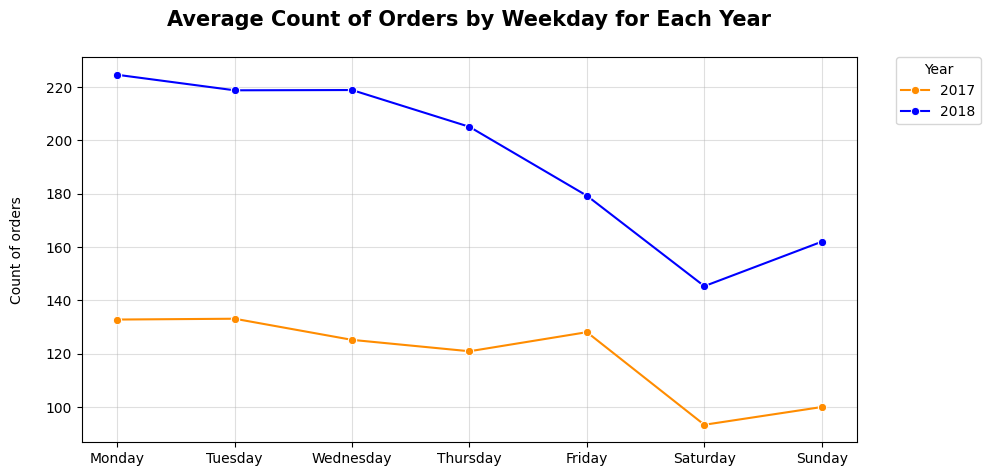

In [58]:
# weekly_counts = orders_by.groupby(['day', 'year']).size().reset_index(name='order_count')
plt.figure(figsize=(10, 5))
sns.lineplot(x='day', y='avg_order_count', hue='year', data=weekly_counts, 
             hue_order=sorted(weekly_counts['year'].unique()), palette=['darkorange','blue'], marker='o', linestyle = '-')
plt.title('Average Count of Orders by Weekday for Each Year\n', fontsize=15, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
# plt.yticks(range(4000,11000,1000))
plt.ylabel("Count of orders\n")
plt.xlabel("")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(visible=True, alpha=0.4)
plt.show()

In [59]:
average_orders_by_day

,day,avg_order_count
0,Monday,178.641026
1,Tuesday,175.884615
2,Wednesday,171.974359
3,Thursday,162.942308
4,Friday,153.608974
5,Saturday,119.304487
6,Sunday,130.964925


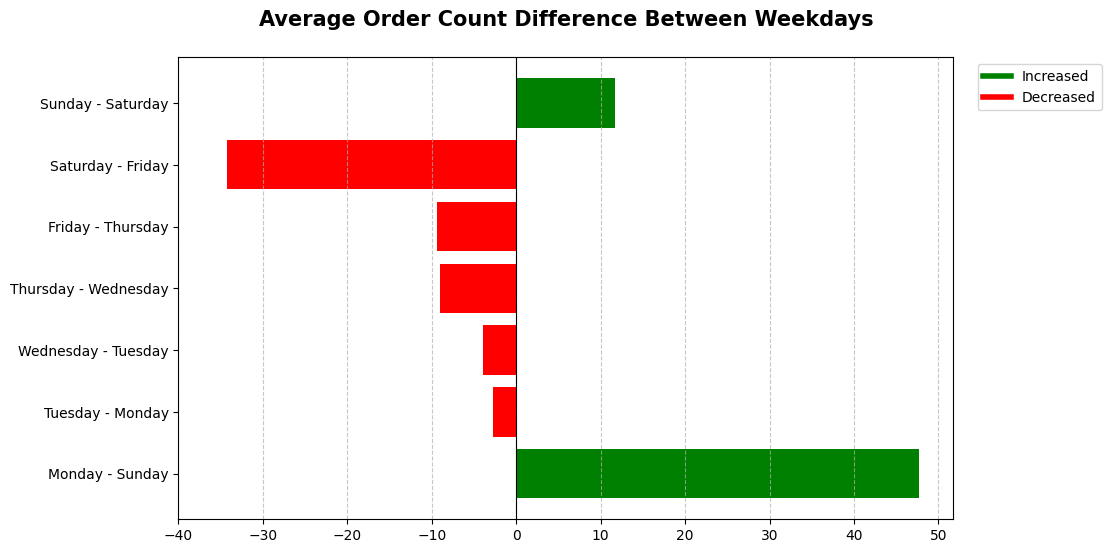

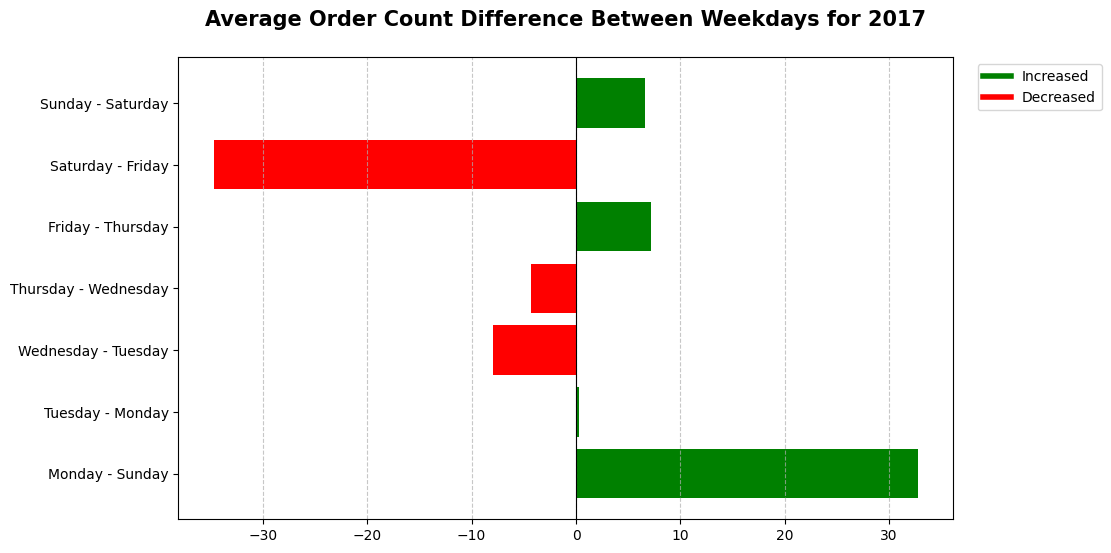

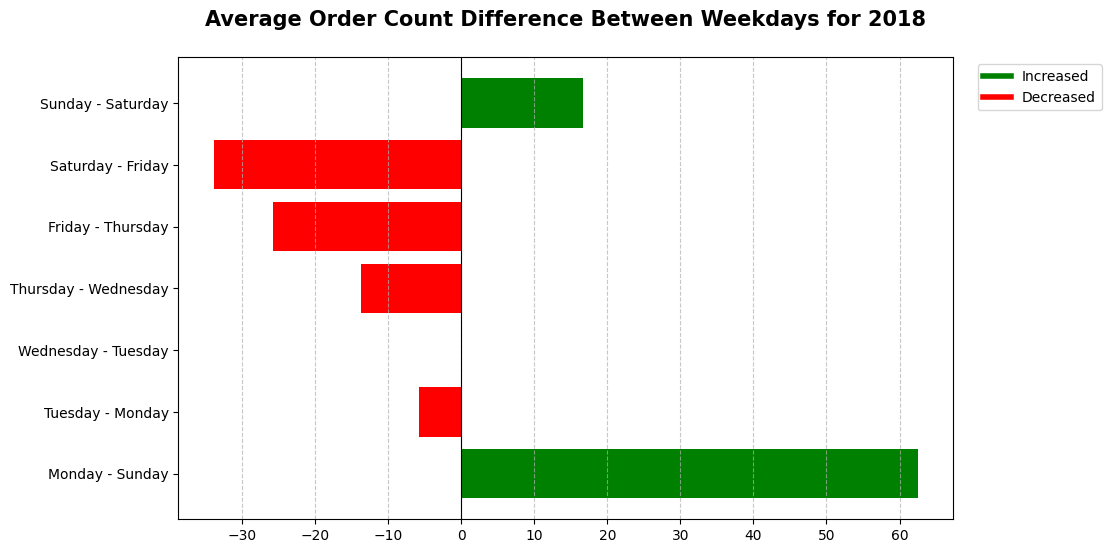

In [60]:
# Convert 'day' column to string type
weekly_counts['day'] = weekly_counts['day'].astype(str)
weekly_counts['day_order'] = pd.Categorical(weekly_counts['day'], categories=weekday_order, ordered=True)
# Sort by year and day order
weekly_counts = weekly_counts.sort_values(by=['year', 'day_order'])
# Calculate the difference in avg_order_count between consecutive weekdays within each year
weekly_counts['difference'] = weekly_counts.groupby('year')['avg_order_count'].diff()
# Create a new column for day comparisons
weekly_counts['day_comparison'] = weekly_counts['day'] + ' - ' + weekly_counts['day'].shift(1) 


average_orders_by_day['day'] = average_orders_by_day['day'].astype(str)
average_orders_by_day['day_order'] = pd.Categorical(average_orders_by_day['day'], categories=weekday_order, ordered=True)
average_orders_by_day = average_orders_by_day.sort_values(by= 'day_order')
average_orders_by_day['difference'] = average_orders_by_day['avg_order_count'].diff()
average_orders_by_day['day_comparison'] = average_orders_by_day['day'] + ' - ' + average_orders_by_day['day'].shift(1) 
average_orders_by_day.iloc[0,4] = "Monday - Sunday"
average_orders_by_day.iloc[0,3] = average_orders_by_day.iloc[0,1] - average_orders_by_day.iloc[6,1]
plt.figure(figsize=(10, 6))
plt.barh(average_orders_by_day['day_comparison'], average_orders_by_day['difference'], 
         color=(average_orders_by_day['difference'] > 0).map({True: 'green', False: 'red'}))
plt.axvline(0, color='black', linewidth=0.8)
plt.title(f'Average Order Count Difference Between Weekdays\n', fontsize=15, fontweight='bold')
plt.xlabel('\n')
plt.ylabel('')
handles = [plt.Line2D([0], [0], color='green', lw=4, label='Increased'),
           plt.Line2D([0], [0], color='red', lw=4, label='Decreased')]
plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(range(-40,60,10))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Create plots for each year
for year in weekly_counts['year'].unique():
    yearly_data = weekly_counts[weekly_counts['year'] == year]
    yearly_data.iloc[0,7] = "Monday - Sunday"
    yearly_data.iloc[0,6] = yearly_data.iloc[0,4] - yearly_data.iloc[6,4]
    plt.figure(figsize=(10, 6))
    plt.barh(yearly_data['day_comparison'], yearly_data['difference'], 
             color=(yearly_data['difference'] > 0).map({True: 'green', False: 'red'}))

    plt.axvline(0, color='black', linewidth=0.8)  # Add vertical line at x=0
    plt.title(f'Average Order Count Difference Between Weekdays for {year}\n', fontsize=15, fontweight='bold')
    plt.xlabel('\n')
    plt.ylabel('')
    if year == 2017:
        plt.xticks(range(-30,40,10))
    else:
        plt.xticks(range(-30,70,10))
    handles = [plt.Line2D([0], [0], color='green', lw=4, label='Increased'),
               plt.Line2D([0], [0], color='red', lw=4, label='Decreased')]
    plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


### Analysis about Sales Amount

In [61]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

locations = pd.read_sql("""
    SELECT
        geolocation_lat AS lat,
        geolocation_lng AS long,
        INITCAP(geolocation_city) AS city,
        geolocation_state AS state
    FROM geolocations
""", engine)
engine.dispose()

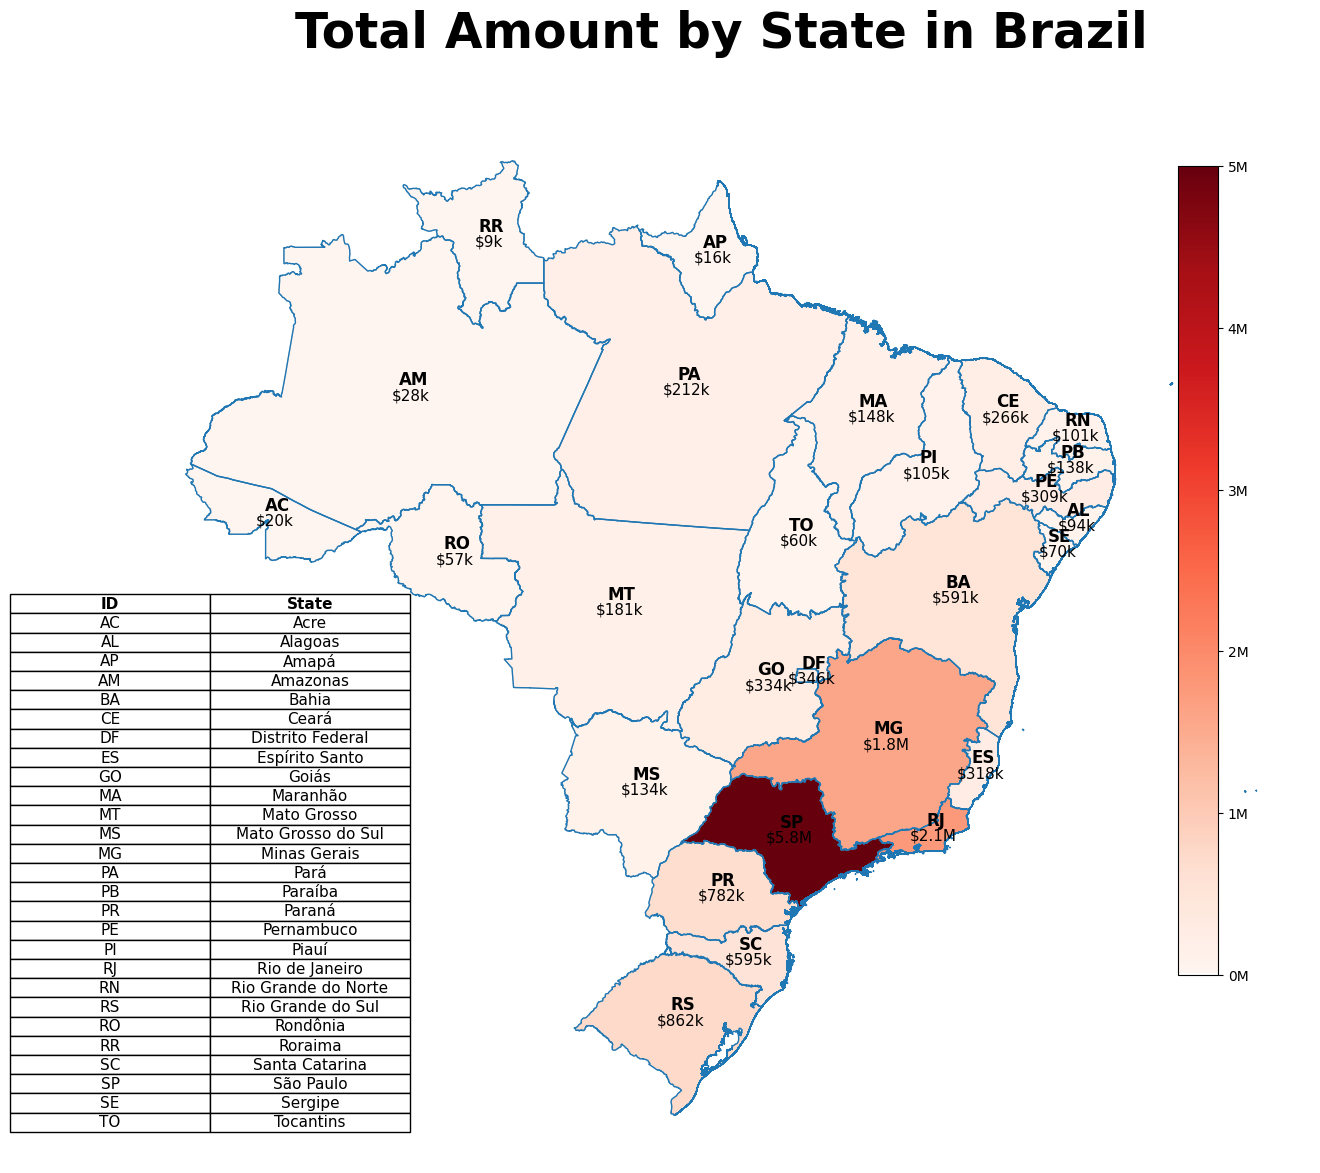

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

# Group orders by state and count
orders_by_state = orders_amount.groupby('state', observed = False).agg(
                            total_amount = ('payment_value', 'sum')
                            ).reset_index()

# Create a mapping from state abbreviations to full names
state_mapping = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AM': 'Amazonas', 'AP': 'Amapá',
    'BA': 'Bahia', 'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo',
    'GO': 'Goiás', 'MA': 'Maranhão', 'MG': 'Minas Gerais', 'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso', 'PA': 'Pará', 'PB': 'Paraíba', 'PE': 'Pernambuco',
    'PI': 'Piauí', 'PR': 'Paraná', 'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte',
    'RO': 'Rondônia', 'RR': 'Roraima', 'RS': 'Rio Grande do Sul',
    'SC': 'Santa Catarina', 'SE': 'Sergipe', 'SP': 'São Paulo', 'TO': 'Tocantins'
}

# Map the state abbreviations to full names
orders_by_state['state'] = orders_by_state['state'].map(state_mapping)

# Function to format the order count
def format_count(x):
    if pd.isnull(x):
        return "0"
    elif x >= 1000000:
        return f'${x / 1000000:,.1f}M'
    elif x >= 1000:
        return f'${x / 1000:,.0f}k'
    else:
        return f'${x:,.0f}'

# Create a new column for formatted counts in the orders_by_state DataFrame
orders_by_state['formatted_count'] = orders_by_state['total_amount'].apply(format_count)

# Merge GeoDataFrame with order data
brazil_map = brazil_geo.merge(orders_by_state, left_on='name', right_on='state', how='left')

# Plot the map with color coding based on order counts
fig, ax = plt.subplots(1, 1, figsize=(20, 15))  # Increased figure size
brazil_map.boundary.plot(ax=ax, linewidth=1)

# Use a continuous color map from white to red
plot = brazil_map.plot(
    column="total_amount", cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8"
)

# Add the color bar manually
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=brazil_map["total_amount"].min(), vmax=brazil_map["total_amount"].max() // 1000000 * 1000000))
sm._A = []  # Empty array for the ScalarMappable
colorbar = fig.colorbar(sm, ax=ax, shrink=0.7)

# Format color bar to show values in "k" (thousands)
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([f"{int(tick/1000000)}M" for tick in colorbar.get_ticks()])

# Adjust the position of the axis
ax.set_position([0.1, 0.1, 0.75, 0.7])  # [left, bottom, width, height]

# Add formatted count as text annotations on each state
for _, row in brazil_map.iterrows():
    # Position for formatted order count
    plt.text(
        row.geometry.centroid.x + 0.2,
        row.geometry.centroid.y - 0.3,
        row['formatted_count'],
        ha="center",
        fontsize=11,
        color="black"
    )
    
    # Position for state names
    plt.text(
        row.geometry.centroid.x + 0.3,
        row.geometry.centroid.y + 0.3,
        row['id'],
        ha="center",
        fontsize=12,
        color="black",
        fontweight='bold'
    )

# Create a table with order counts on the right side
table_data = orders_by_state[['state', 'formatted_count']]
table_data.columns = ['State', '']

# Hide axes
ax.axis("off") 

# Create a new axes for the table with adjusted size
table_ax = fig.add_axes([0.2, 0.1, 0.2, 0.4])  # Position of the table [left, bottom, width, height]
table_ax.axis('tight')
table_ax.axis('off')

table_data = brazil_map[['id', 'name']]
table_data.columns = ['ID', 'State']

# Create the table with increased height
table = table_ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Format table cell text size and height
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(12)  # Adjust font size
    cell.set_edgecolor('black')  # Add border
    # Increase the height of the rows
    cell.set_height(0.032)  # Adjust this value as needed to increase row height

    # Make the first row bold (header row)
    if i == 0:  # Check if it's the header row
        cell.set_text_props(fontweight='bold')
    else:
        if j == 0:  # ID column (only for non-header rows)
            cell.set_text_props(fontweight='normal')  # Regular weight for ID
        if j == 1:  # State column (only for non-header rows)
            cell.set_text_props(fontweight='normal')  # Regular weight for state

ax.set_title("Total Amount by State in Brazil\n", fontsize=35, fontweight='bold')  # Increased title font size
plt.show()


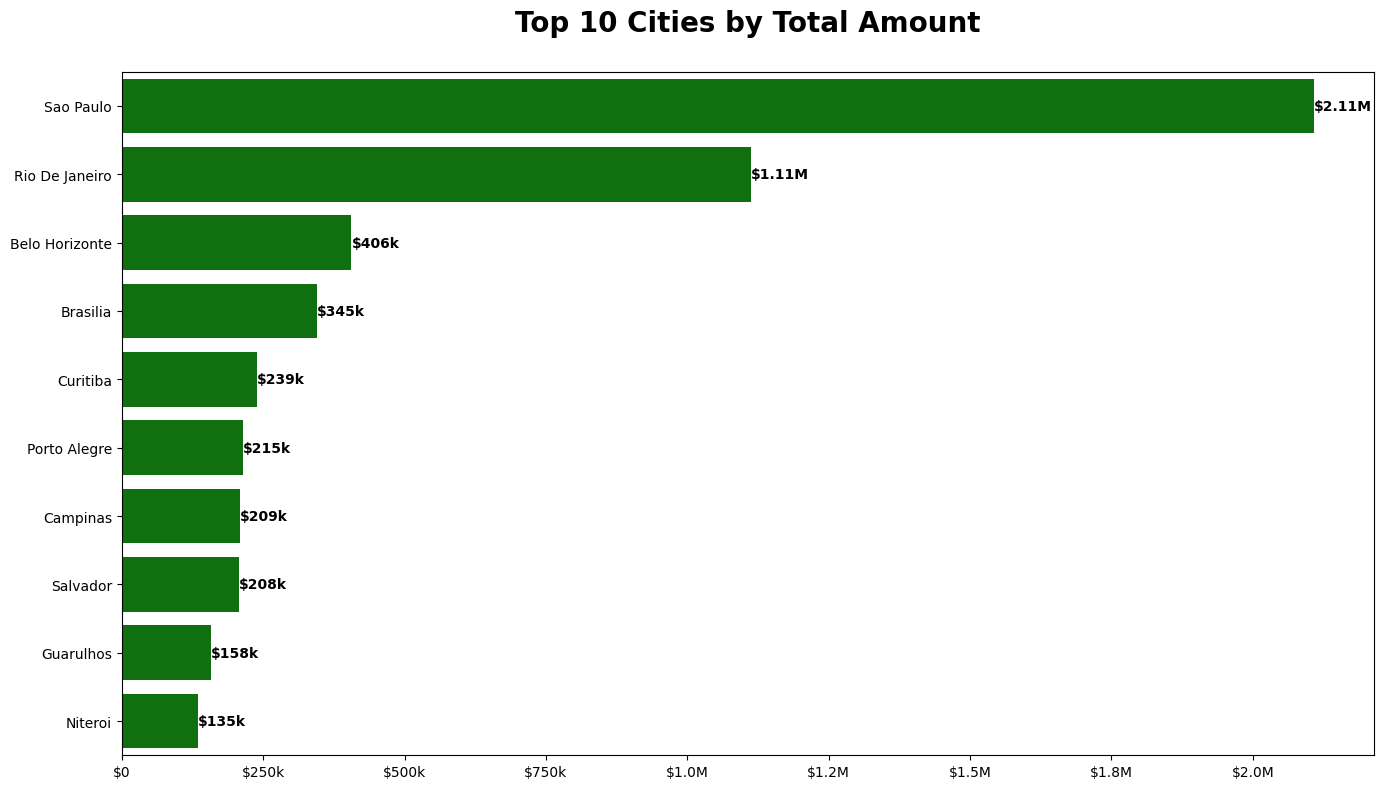

In [63]:
import matplotlib.ticker as mtick

def custom_format(x, _):
    if x >= 1_000_000:
        return f'${x / 1_000_000:,.1f}M'
    elif x >= 1_000:
        return f'${x / 1_000:,.0f}k'
    else:
        return f'${x:,.0f}'
        
top_cities = orders_amount.groupby("city",observed = False).agg(
    total_amount = ("payment_value", "sum")
).reset_index().sort_values(by=['total_amount'], ascending=False)[:10]
top_cities["city"] = top_cities["city"].astype(str)

plt.figure(figsize=(14, 8))
barplot = sns.barplot(y='city', x='total_amount', data=top_cities, color='green', orient = 'h')
plt.title('Top 10 Cities by Total Amount\n', fontsize=20, fontweight='bold')
plt.ylabel("")  # Removes y-axis label
plt.xlabel("")  # Removes x-axis label

# Format the x-axis with custom currency formatting
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(custom_format))

# Add labels to each bar
for bar in barplot.containers[0]:
    bar_value = bar.get_width()  # Width is used for the value in a horizontal bar plot
    if bar_value >= 1_000_000:
        label = f'${bar_value / 1_000_000:,.2f}M'
    elif bar_value >= 1_000:
        label = f'${bar_value / 1_000:,.0f}k'
    else:
        label = f'${bar_value:,.0f}'
    plt.text(
        bar_value,  # Place label slightly right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        label, ha='left', va='center', fontsize=10, color='black',fontweight = 'bold'
    )
plt.tight_layout()
plt.show()

In [64]:
yearly_amount = orders_amount.groupby('year').agg(
    payment_mean=('payment_value', 'mean'), 
    payment_sum=('payment_value', 'sum')
).reset_index()
yearly_amount = yearly_amount[yearly_amount["year"] != 2016]
yearly_amount.head()

,year,payment_mean,payment_sum
1,2017,151.402958,6922900.24
2,2018,154.397881,8452975.20


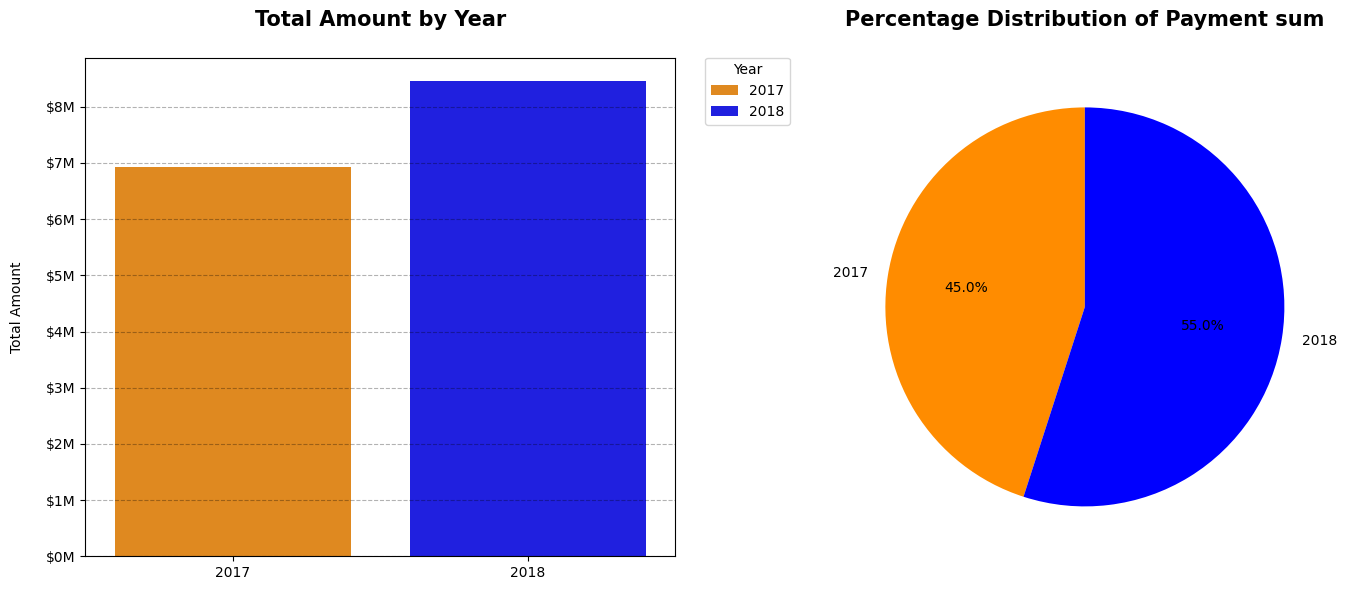

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Bar plot for Total Amount by Year
plt.subplot(1, 2, 1)
sns.barplot(x='year', y='payment_sum', data=yearly_amount, hue='year', palette=['darkorange', 'blue'])
plt.title('Total Amount by Year\n', fontsize=15, fontweight='bold')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000000:,.0f}M'))
plt.ylabel("Total Amount\n")
plt.xlabel("")
plt.grid(visible=True, axis='y', alpha=0.3, color='black', linestyle='--')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Pie chart for Payment Mean Distribution
plt.subplot(1, 2, 2)
payment_sum_values = yearly_amount['payment_sum']
labels = yearly_amount['year']
colors = ['darkorange', 'blue']
plt.pie(payment_sum_values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Payment sum\n', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_4948\2616211308.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='year', y='payment_mean',data=yearly_amount, palette=['darkorange', 'blue'])


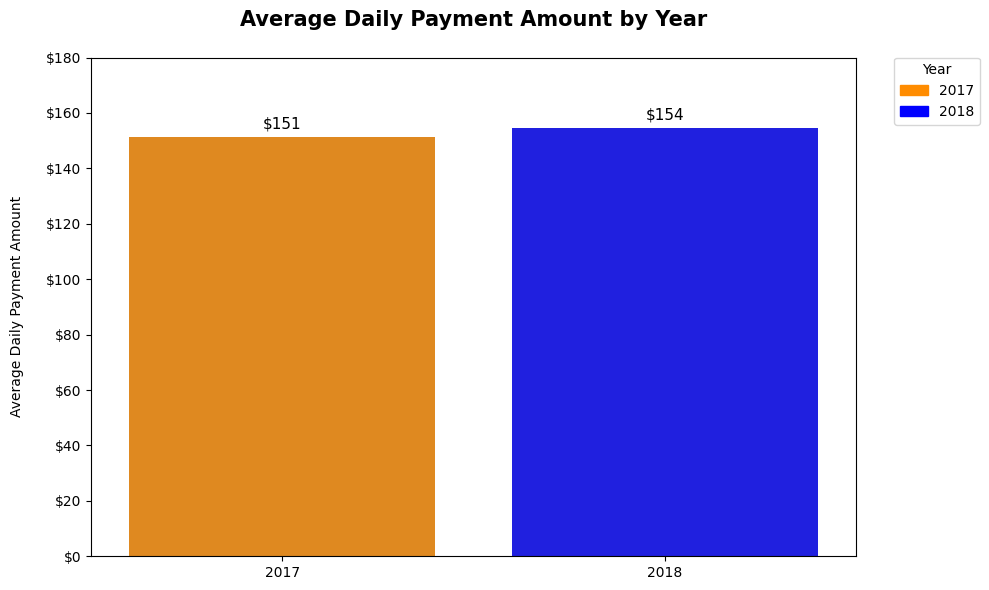

In [66]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='year', y='payment_mean',data=yearly_amount, palette=['darkorange', 'blue'])
plt.title('Average Daily Payment Amount by Year\n', fontsize=15, fontweight='bold')
plt.ylabel("Average Daily Payment Amount\n")
plt.xlabel("")
plt.yticks(range(0, 190, 20))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, bar in enumerate(barplot.patches):
    y_val = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, y_val + 2,  # Position the text slightly above the bar
        f'${y_val:,.0f}',  # Format the label as currency
        ha='center', va='bottom', fontsize=11, color='black'
    )
import matplotlib.patches as mpatches
orange_patch = mpatches.Patch(color='darkorange', label='2017')
blue_patch = mpatches.Patch(color='blue', label='2018')
plt.legend(handles=[orange_patch, blue_patch], title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


In [67]:
monthly_amount = orders_amount.groupby(['year', 'month'], observed = 'False').agg(
    payment_sum=('payment_value', 'sum')
).reset_index()
monthly_amount = monthly_amount[monthly_amount["year"] != 2016].drop('year', axis = 1)
monthly_amount = monthly_amount.groupby('month', observed = 'False').agg(
    average_amount =('payment_sum', 'mean')
).reset_index()

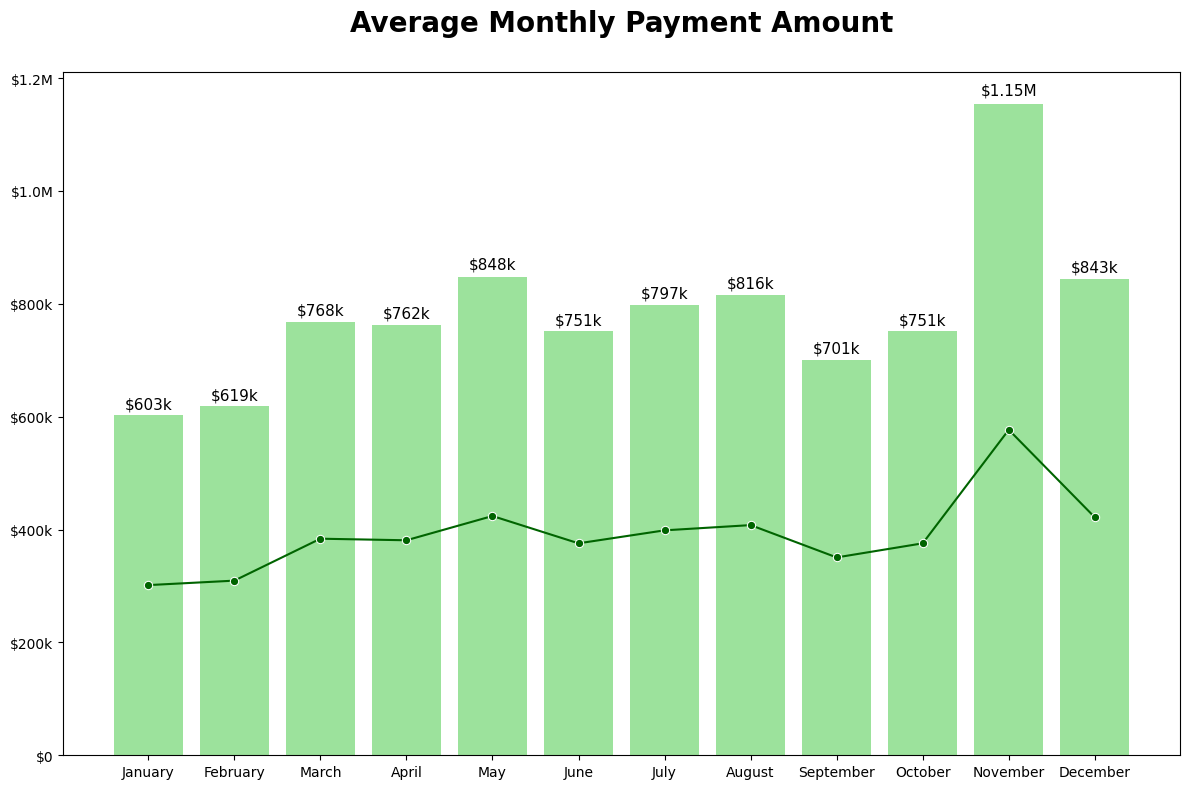

In [68]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='month', y='average_amount', data=monthly_amount, color='lightgreen')

sns.lineplot(x='month', y=monthly_amount['average_amount'] // 2, data=monthly_amount, 
             marker='o', color='darkgreen')
plt.title('Average Monthly Payment Amount\n', fontsize=20, fontweight='bold')
plt.ylabel("")
plt.xlabel("")

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(custom_format))
for bar in barplot.patches:
    y_val = bar.get_height()
    if y_val >= 1_000_000:
        label = f'${y_val / 1_000_000:,.2f}M'
    elif y_val >= 1_000:
        label = f'${y_val / 1_000:,.0f}k'
    else:
        label = f'${y_val:,.0f}'
        
    plt.text(
        bar.get_x() + bar.get_width() / 2, y_val + (y_val * 0.01),  # Slightly above bar
        label, ha='center', va='bottom', fontsize=11, color='black'
    )
plt.tight_layout()
plt.show()


In [69]:
daily_amount = orders_amount.groupby('day', observed = 'False').agg(
    average_amount=('payment_value', 'mean')
).reset_index()

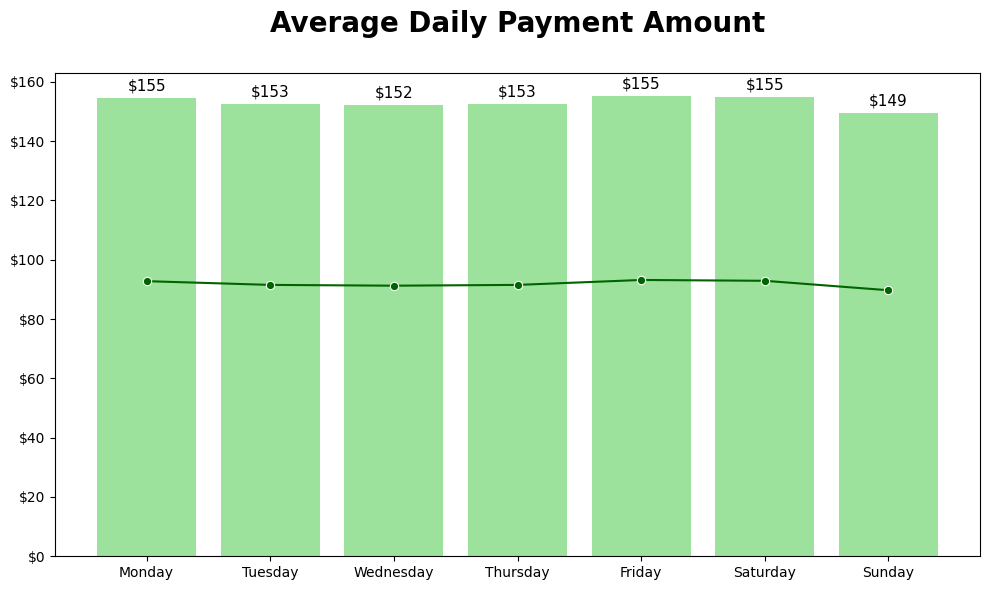

In [70]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='day', y='average_amount', data=daily_amount, color='lightgreen')

sns.lineplot(x='day', y=daily_amount['average_amount'] * 0.6, data=daily_amount, 
             marker='o', color='darkgreen')
plt.title('Average Daily Payment Amount\n', fontsize=20, fontweight='bold')
plt.ylabel("")
plt.xlabel("")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar in barplot.patches:
    y_val = bar.get_height()
    label = f'${y_val:,.0f}'
        
    plt.text(
        bar.get_x() + bar.get_width() / 2, y_val + (y_val * 0.01),  # Slightly above bar
        label, ha='center', va='bottom', fontsize=11, color='black'
    )
plt.tight_layout()
plt.show()

### Analysis About Payment

In [71]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
pay_type = pd.read_sql("""
    SELECT 
        INITCAP(payment_type) AS payment_type,
        COUNT(payment_type)
    FROM payments
    GROUP BY payment_type
    ORDER BY count DESC;
""", engine)
engine.dispose()

In [72]:
pay_type["payment_type"] = pay_type["payment_type"].str.replace("_", " ")

In [73]:
pay_type

,payment_type,count
0,Credit Card,76795
1,Boleto,19784
2,Voucher,5775
3,Debit Card,1529
4,Not Defined,3


In [74]:
pay_type.iloc[0, 1] = pay_type.iloc[0, 1] + pay_type.iloc[4, 1]
pay_type = pay_type[pay_type["payment_type"] != "Not Defined"]
pay_type

,payment_type,count
0,Credit Card,76798
1,Boleto,19784
2,Voucher,5775
3,Debit Card,1529


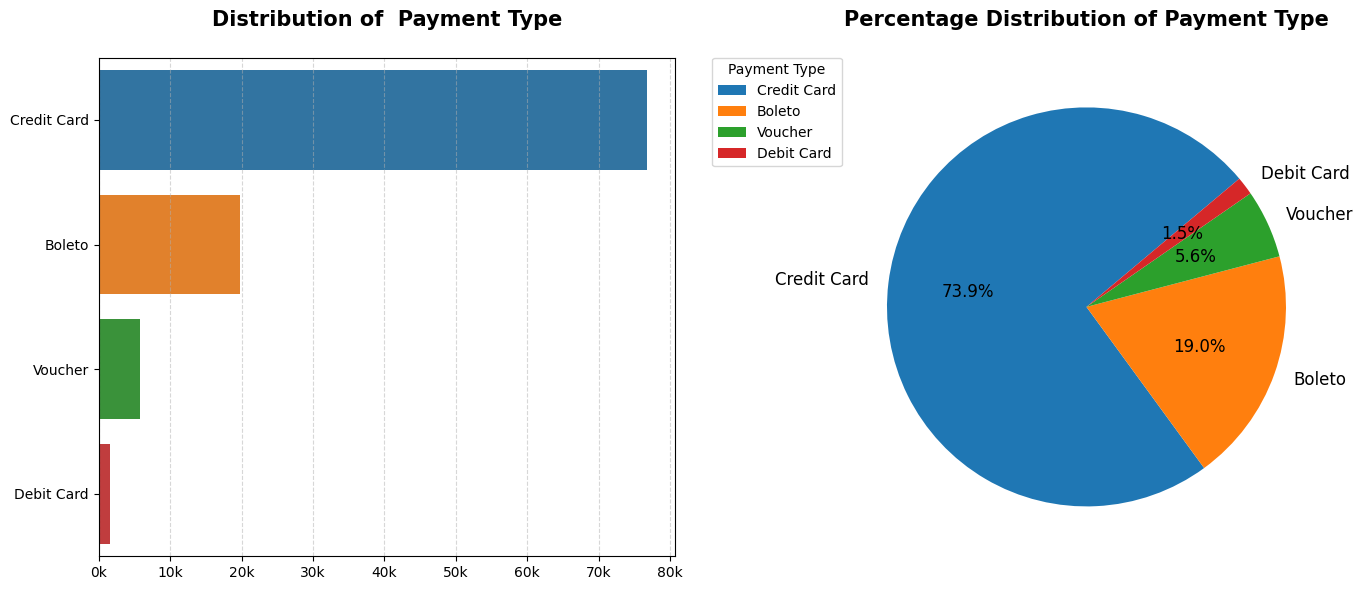

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Bar plot for Total Amount by Year
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='payment_type', data=pay_type, hue='payment_type')
plt.title('Distribution of  Payment Type\n', fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.ylabel("")
plt.xlabel("")
plt.grid(visible=True, axis='x', alpha=0.5, linestyle='--')

# Pie chart for Payment Mean Distribution
plt.subplot(1, 2, 2)
payment_sum_values = pay_type['count']
labels = pay_type['payment_type']
plt.pie(payment_sum_values, labels=labels, autopct='%1.1f%%', startangle=40, textprops={'color': 'black', 'fontsize' : '12'})
plt.title('Percentage Distribution of Payment Type\n', fontsize=15, fontweight='bold')
plt.legend(title='Payment Type', bbox_to_anchor=(-0.25, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [76]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
pay_seq = pd.read_sql("""
    SELECT 
        payment_sequential AS seq,
        COUNT(payment_sequential)
    FROM payments
    GROUP BY payment_sequential
    ORDER BY count DESC;
""", engine)
engine.dispose()

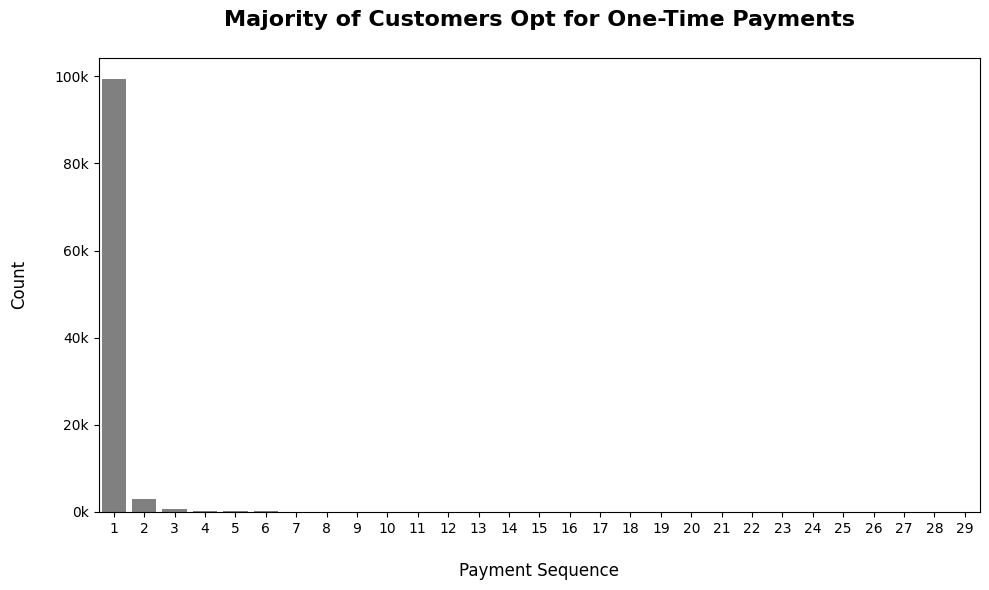

In [77]:
plt.figure(figsize=(10, 6))
sns.barplot(x='seq', y='count', data=pay_seq, color='gray')

plt.title("Majority of Customers Opt for One-Time Payments\n", fontsize=16, fontweight='bold')
plt.xlabel("\nPayment Sequence", fontsize=12)
plt.ylabel("Count\n", fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
plt.tight_layout()
plt.show()

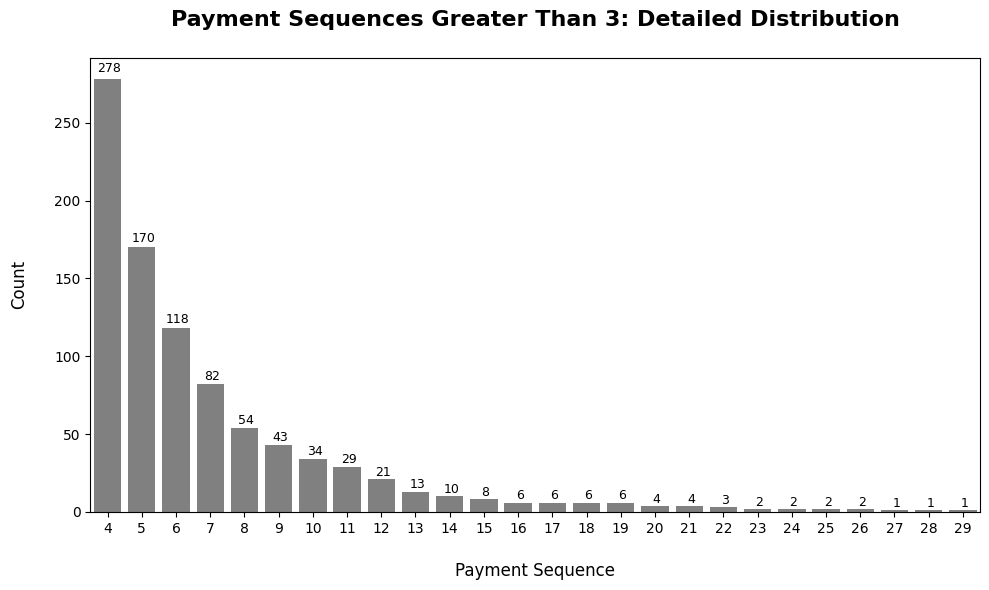

In [78]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='seq', y='count', data=pay_seq[3:], color='gray')

plt.title("Payment Sequences Greater Than 3: Detailed Distribution\n", fontsize=16, fontweight='bold')
plt.xlabel("\nPayment Sequence", fontsize=12)
plt.ylabel("Count\n", fontsize=12)
for bar in barplot.patches:
    y_val = bar.get_height()
    label = f'{y_val:,.0f}' 
    plt.text(
        bar.get_x() + bar.get_width() / 2 + 0.05, y_val + (y_val * 0.01),  # Slightly above bar
        label, ha='center', va='bottom', fontsize=9, color='black'
    )
plt.tight_layout()
plt.show()

In [79]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
pay_val = pd.read_sql("""
    SELECT SUM(payment_value) AS payment_value
    FROM payments
    GROUP BY order_id
    HAVING SUM(payment_value) <> 0
""", engine)
engine.dispose()

In [116]:
print(f"Min - {pay_val['payment_value'].min()}$")
print(f"Max - {pay_val['payment_value'].max()}$")
print(f"Median - {pay_val['payment_value'].median():.2f}$")
print(f"Mean - {pay_val['payment_value'].mean():.0f}$")
print(f"STD - {pay_val['payment_value'].std():.2f}$")

Min - 9.59$
Max - 13664.08$
Median - 105.29$
Mean - 161$
STD - 221.95$


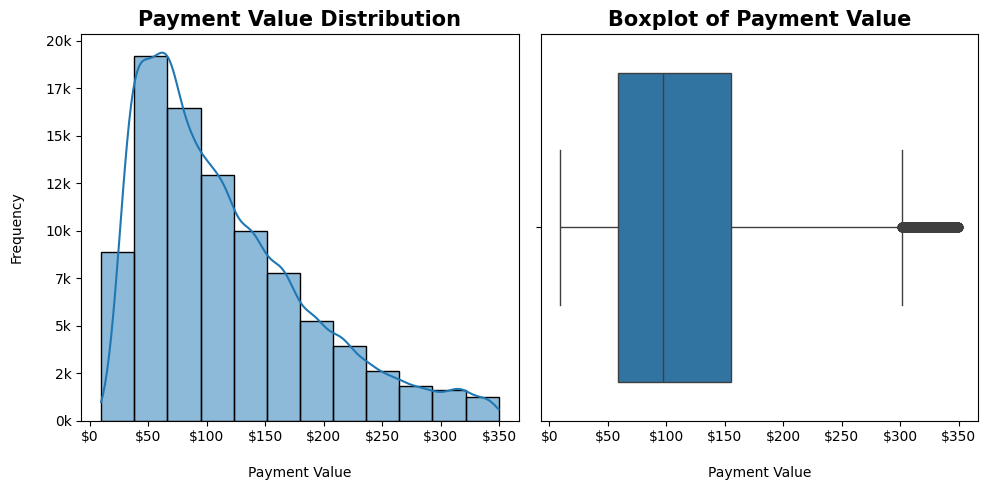

In [115]:
Q1 = pay_val["payment_value"].quantile(0.25)
Q3 = pay_val["payment_value"].quantile(0.75)
IQR = Q3 - Q1
filtered_pay_val = pay_val[(pay_val["payment_value"] >= Q1 - 1.5 * IQR) & (pay_val["payment_value"] <= Q3 + 1.5 * IQR)]
x = filtered_pay_val["payment_value"]
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(x=x, kde=True, bins=12)
plt.ylabel("Frequency\n")
plt.xlabel("\nPayment Value")
plt.title("Payment Value Distribution", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(custom_format))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x // 1000:,.0f}k"))

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=x, orient='h', showfliers=True)
plt.xlabel("\nPayment Value")
plt.title("Boxplot of Payment Value", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(custom_format))

plt.tight_layout()
plt.show()

### Analysis About Products

In [82]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
top_prod = pd.read_sql("""
    SELECT 
        INITCAP(REPLACE(p.product_category_name, '_', ' ')) AS category, 
        COUNT(p.product_category_name) AS count
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    LEFT JOIN products p ON oi.product_id = p.product_id
    GROUP BY category
    ORDER BY count DESC;
""", engine)

prices = pd.read_sql("""
    WITH esim AS (
        SELECT DISTINCT ON (p.product_id) 
            p.product_id,
            INITCAP(REPLACE(p.product_category_name, '_', ' ')) AS category,
            oi.price
        FROM products p
        JOIN order_items oi ON p.product_id = oi.product_id
    )
    SELECT 
        category, 
        ROUND(AVG(price)::numeric, 2) AS price_mean
    FROM esim
    GROUP BY category;
""", engine)

engine.dispose()
top_prod = top_prod.merge(prices, on="category")

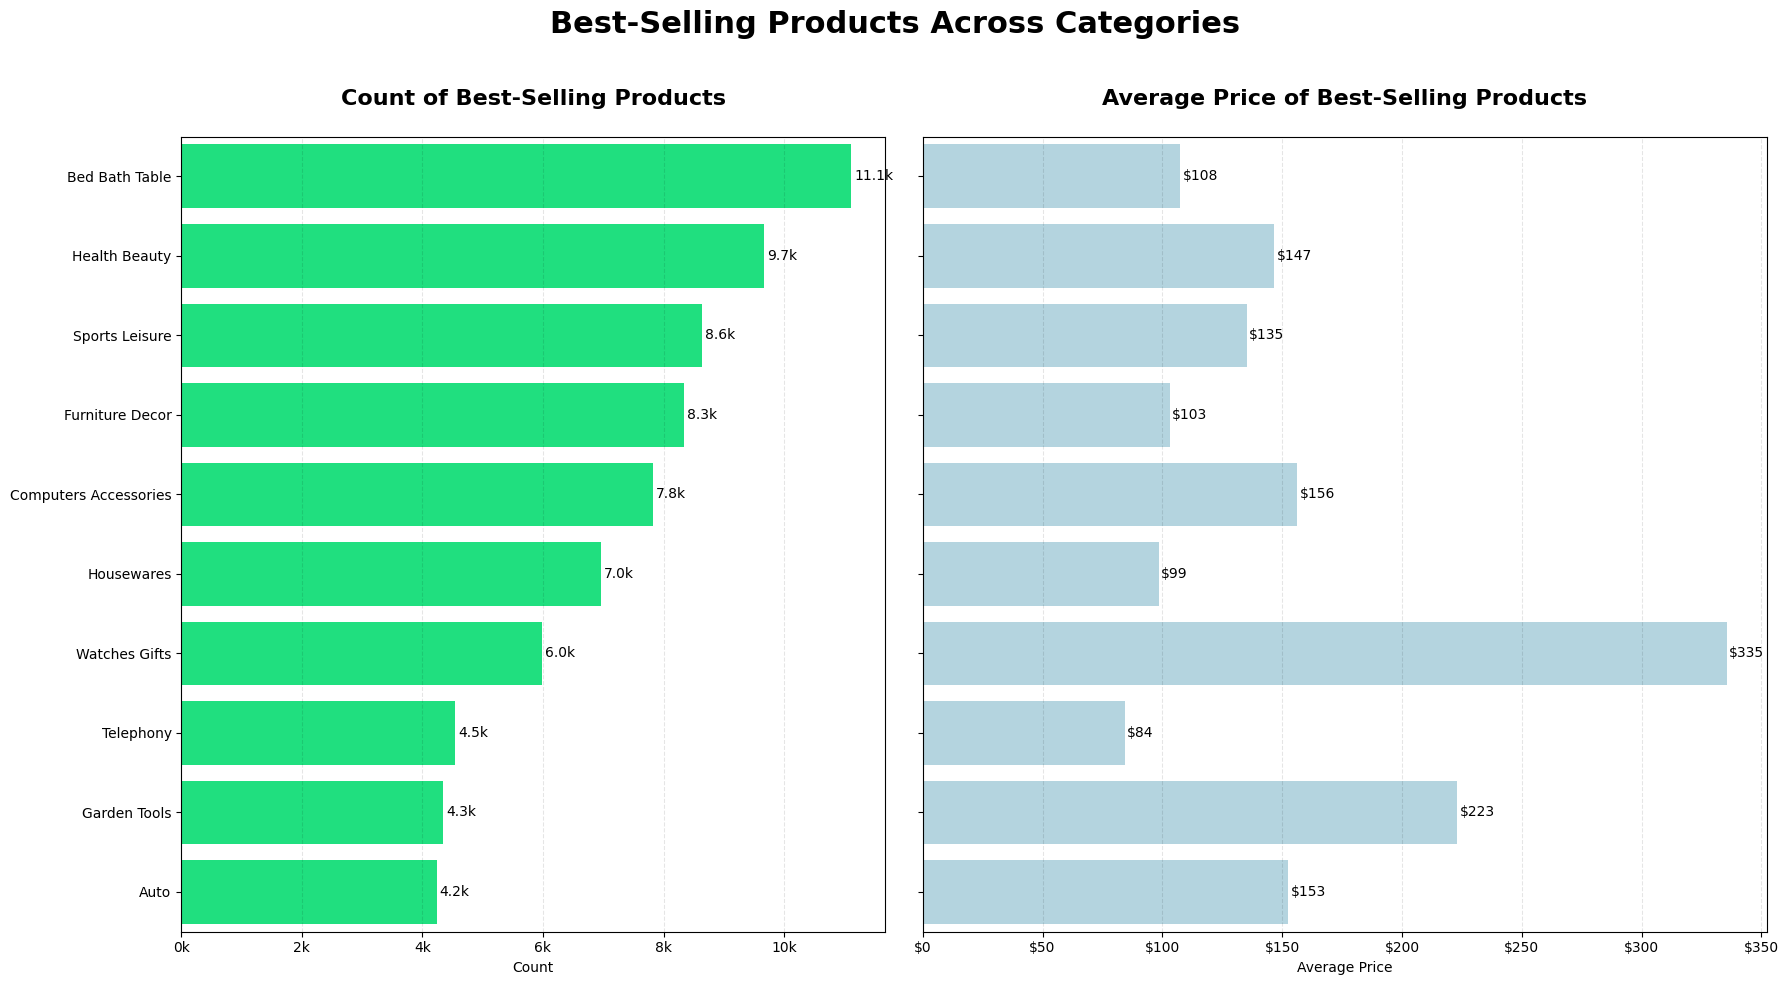

In [83]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

most_prod = top_prod[:10]
# Configure the figure size and layout for side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
plt.suptitle('Best-Selling Products Across Categories', fontsize=22, fontweight='bold')

# Plot 1: Count of Best-Selling Products
sns.barplot(y='category', x='count', data=most_prod, color='springgreen', ax=axes[0], orient='h')
axes[0].set_title('Count of Best-Selling Products\n', fontsize=16, fontweight='bold')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")

# Adding labels to count bars
for bar in axes[0].containers[0]:
    bar_value = bar.get_width()
    if bar_value >= 1_000_000:
        label = f'{bar_value / 1_000_000:,.1f}M'
    elif bar_value >= 1_000:
        label = f'{bar_value / 1_000:,.1f}k'
    else:
        label = f'{bar_value:,.1f}'
    axes[0].text(
        bar_value + 50,
        bar.get_y() + bar.get_height() / 2, 
        label, ha='left', va='center', fontsize=10, color='black'
    )
axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))

# Plot 2: Average Price of Best-Selling Products
sns.barplot(y='category', x='price_mean', data=most_prod, color='lightblue', ax=axes[1], orient='h')
axes[1].set_title('Average Price of Best-Selling Products\n', fontsize=16, fontweight='bold')
axes[1].set_xlabel("Average Price")
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Adding labels to price bars
for bar in axes[1].containers[0]:
    bar_value = bar.get_width()
    label = f'${bar_value:,.0f}'
    axes[1].text(
        bar_value + 1,
        bar.get_y() + bar.get_height() / 2, 
        label, ha='left', va='center', fontsize=10, color='black'
    )

# Apply grid style and layout adjustments
for ax in axes:
    ax.grid(axis='x', alpha=0.1, linestyle='--', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


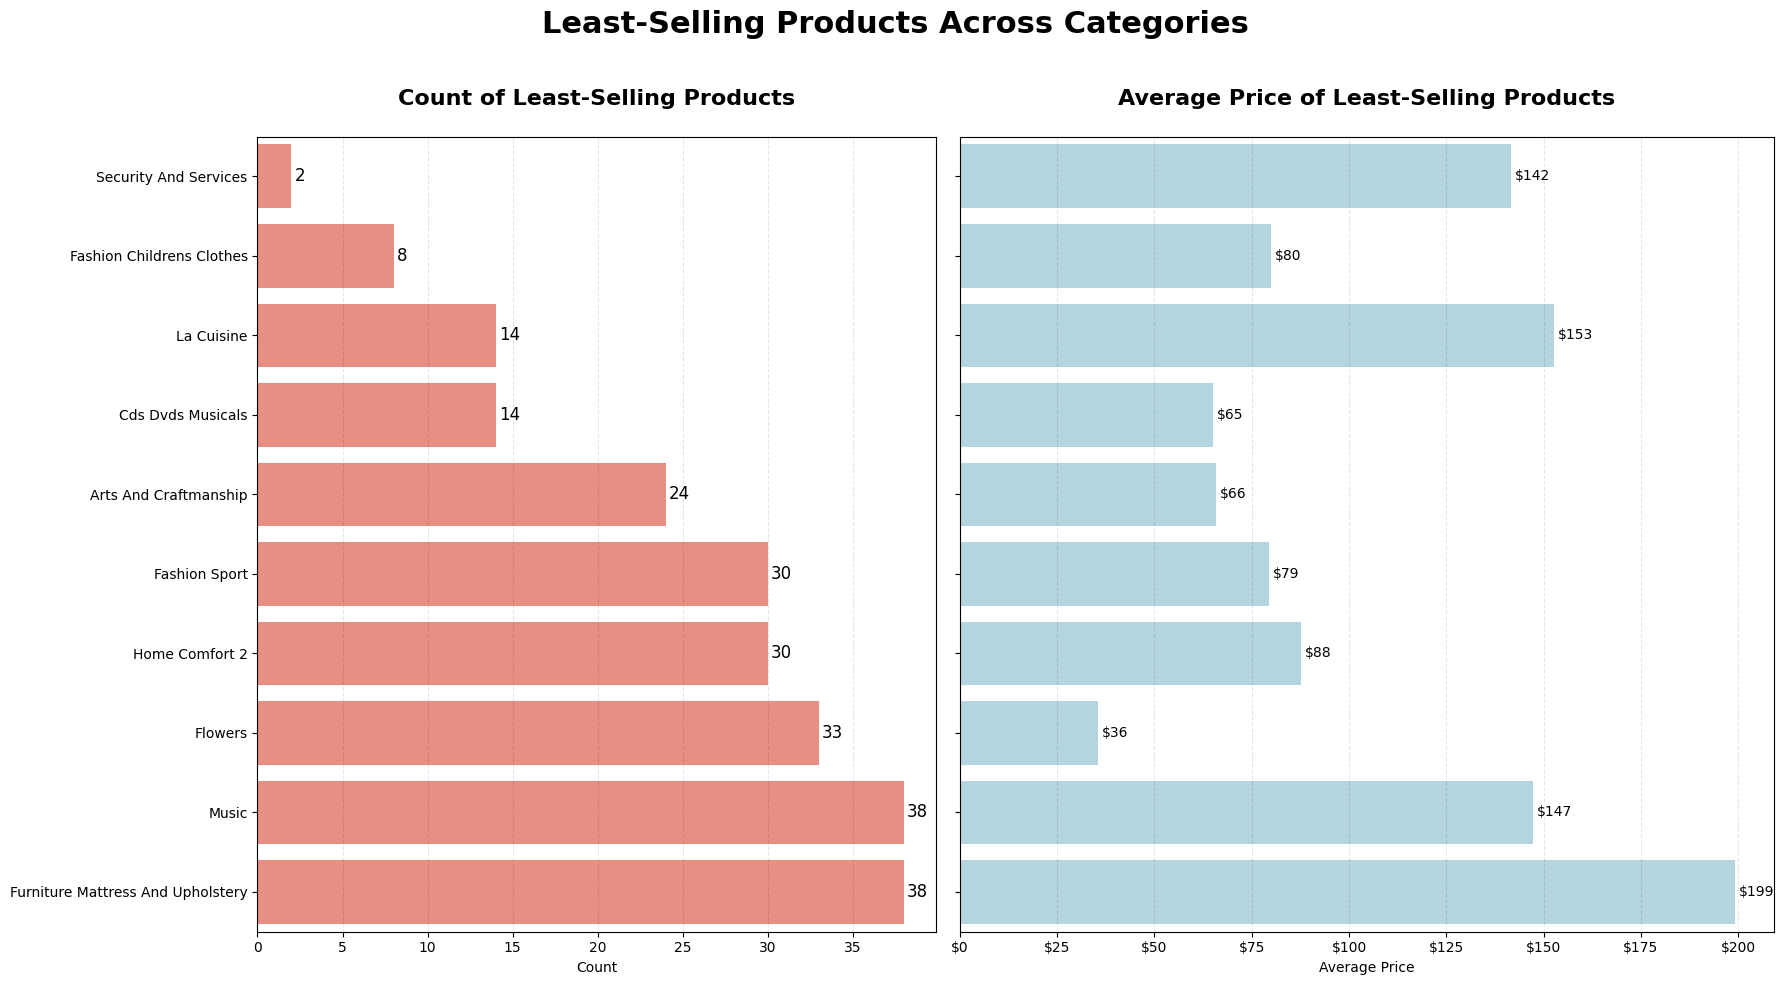

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

least_prod = top_prod[-10:][::-1]
# Configure the figure size and layout
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
plt.suptitle('Least-Selling Products Across Categories', fontsize=22, fontweight='bold')

# Plot 1: Least-Selling Product Counts
sns.barplot(y='category', x='count', data=least_prod, color='salmon', ax=axes[0], orient='h')
axes[0].set_title('Count of Least-Selling Products\n', fontsize=16, fontweight='bold')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")

# Adding labels to count bars
for bar in axes[0].containers[0]:
    bar_value = bar.get_width()
    if bar_value >= 1_000_000:
        label = f'{bar_value / 1_000_000:,.1f}M'
    elif bar_value >= 1_000:
        label = f'{bar_value / 1_000:,.1f}k'
    else:
        label = f'{bar_value:,.0f}'
    axes[0].text(
        bar_value + 0.2,
        bar.get_y() + bar.get_height() / 2,
        label, ha='left', va='center', fontsize=12, color='black'
    )

# Plot 2: Average Price of Least-Selling Products
sns.barplot(y='category', x='price_mean', data=least_prod, color='lightblue', ax=axes[1], orient='h')
axes[1].set_title('Average Price of Least-Selling Products\n', fontsize=16, fontweight='bold')
axes[1].set_xlabel("Average Price")
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Adding labels to price bars
for bar in axes[1].containers[0]:
    bar_value = bar.get_width()
    label = f'${bar_value:,.0f}'
    axes[1].text(
        bar_value + 1,
        bar.get_y() + bar.get_height() / 2,
        label, ha='left', va='center', fontsize=10, color='black'
    )

# Apply grid style and layout adjustments
for ax in axes:
    ax.grid(axis='x', alpha=0.1, linestyle='--', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


In [85]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
top_pairs = pd.read_sql("""
    WITH items AS (
    	SELECT 
    		o.order_id,
    		c.customer_unique_id,
    		INITCAP(REPLACE(p.product_category_name, '_', ' ')) AS category
    	FROM orders o
    	JOIN customers c ON o.customer_id = c.customer_id
    	RIGHT JOIN order_items oi ON o.order_id = oi.order_id
    	LEFT JOIN products p ON oi.product_id = p.product_id
    ), category_pairs AS (
        SELECT 
            a.category AS category1,
            b.category AS category2
        FROM items a
        JOIN items b
    	ON a.customer_unique_id = b.customer_unique_id
    	AND a.order_id = b.order_id
    	AND a.category < b.category
    )
    SELECT 
        category1 || ' & ' || category2 AS categories,
        COUNT(*) AS Purchase_Frequency
    FROM category_pairs
    GROUP BY category1, category2
    ORDER BY Purchase_Frequency DESC
    LIMIT 10;
""", engine)
engine.dispose()

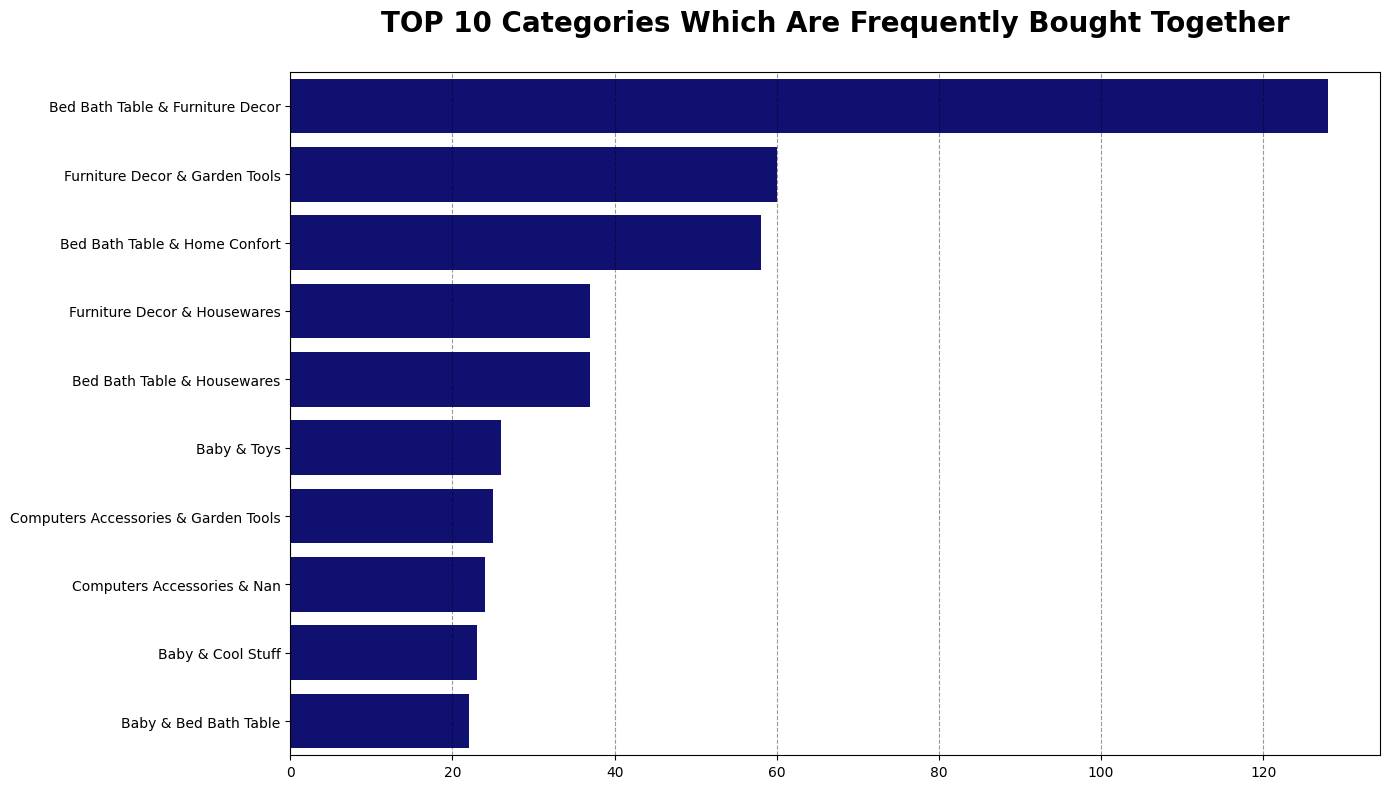

In [86]:
plt.figure(figsize=(14, 8))
barplot = sns.barplot(y='categories', x='purchase_frequency', data=top_pairs, color='navy', orient = 'h')
plt.title('TOP 10 Categories Which Are Frequently Bought Together\n', fontsize=20, fontweight='bold')
plt.ylabel("")
plt.xlabel("")  
plt.grid(axis = 'x',alpha = 0.4,linestyle = '--', color = 'black')
plt.tight_layout()
plt.show()

In [87]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
items_count_freq = pd.read_sql("""
    WITH items AS(
    	SELECT COUNT(order_item_id) AS items_count
    	FROM order_items
    	GROUP BY order_id
    )
    SELECT items_count, COUNT(items_count) AS frequency
    FROM items
    GROUP BY items_count
    ORDER BY items_count
""", engine)
engine.dispose()

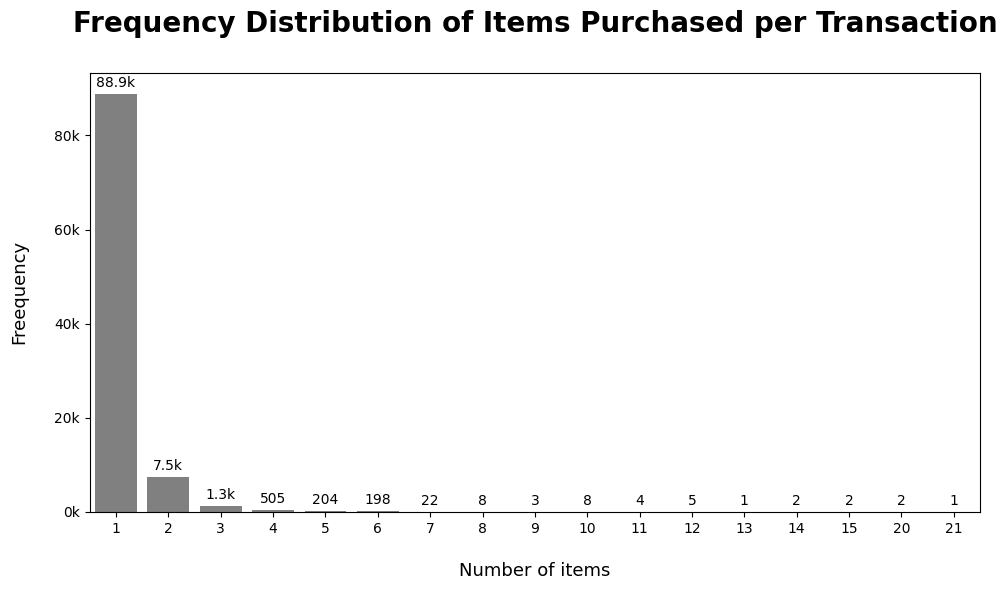

In [88]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='items_count', y='frequency', data=items_count_freq, color='gray')
plt.title('Frequency Distribution of Items Purchased per Transaction\n', fontsize=20, fontweight='bold')
plt.ylabel("Freequency\n",fontsize = 13)
plt.xlabel("\nNumber of items",fontsize = 13)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _ : f"{x // 1000:.0f}k"))
for bar in barplot.patches:
    y_val = bar.get_height()
    if y_val >= 1_000:
        label = f'{y_val / 1_000:,.1f}k'
    else:
        label = f'{y_val:,.0f}' 
    plt.text(
        bar.get_x() + bar.get_width() / 2, y_val + 800,
        label, ha='center', va='bottom', fontsize=10, color='black'
    )
plt.tight_layout()
plt.show()


### Analysis About Sellers

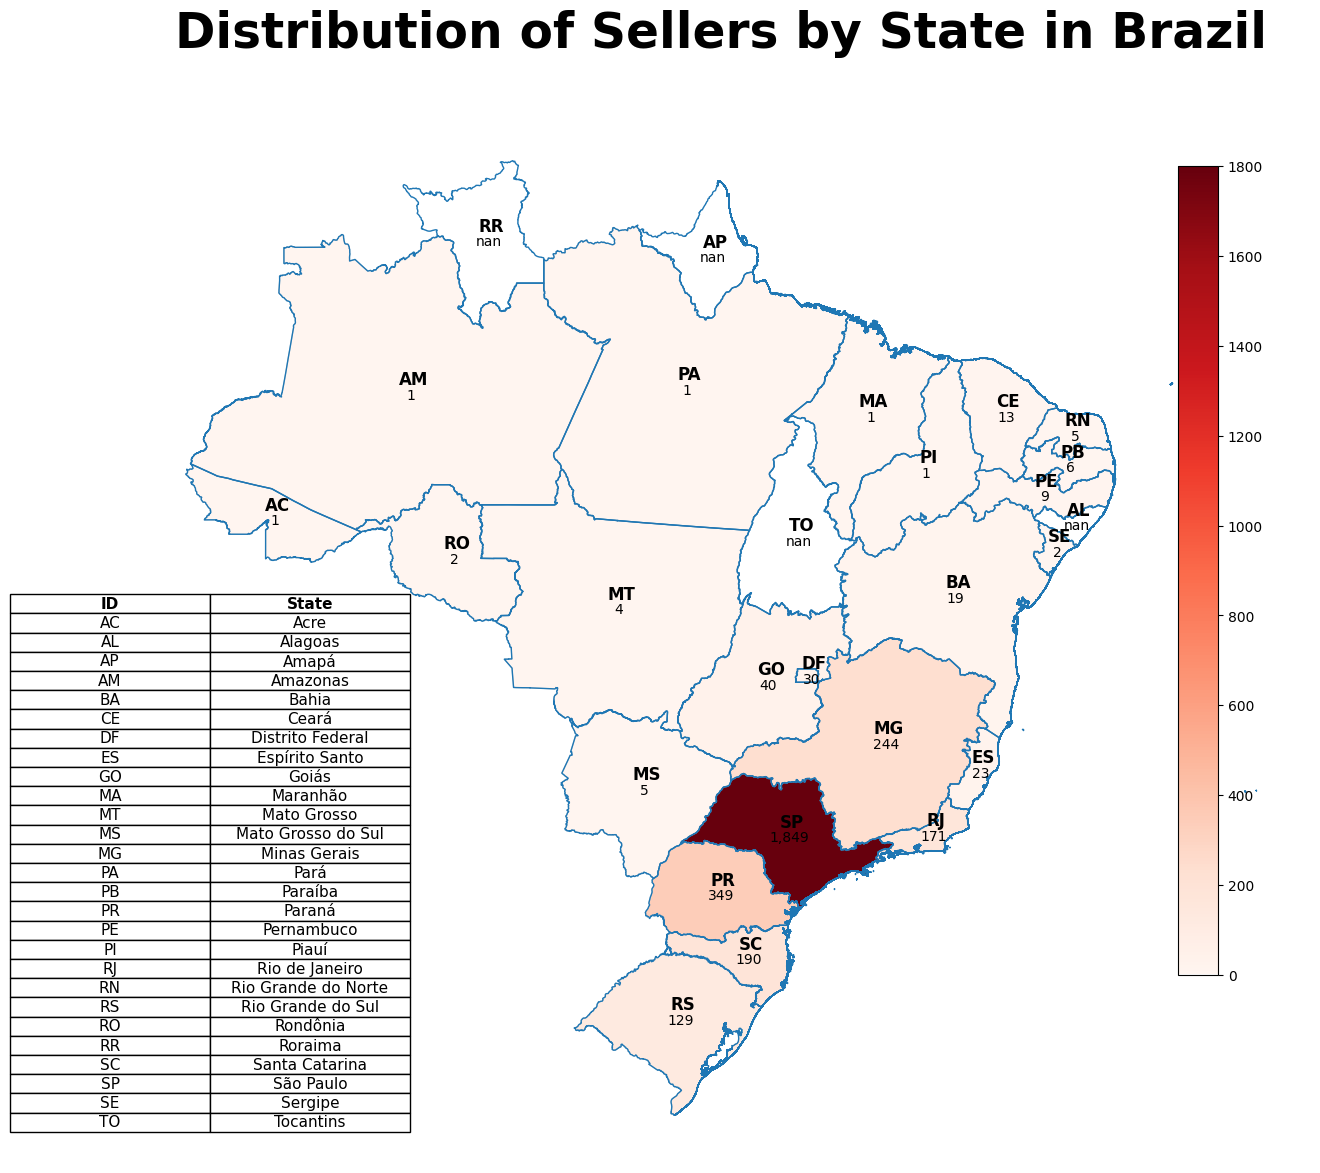

In [95]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
top_sellers = pd.read_sql("""
    SELECT seller_state AS state, COUNT(*) AS seller_count
    FROM sellers
    GROUP BY seller_state
    ORDER BY seller_count DESC
""", engine)
engine.dispose()

top_sellers['state'] = top_sellers['state'].map(state_mapping)

def format_count(x):
    if pd.isnull(x):
        return "0"
    return f"{int(x):,}"

top_sellers['formatted_count'] = top_sellers['seller_count'].apply(format_count)

brazil_map = brazil_geo.merge(top_sellers, left_on='name', right_on='state', how='left')

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
brazil_map.boundary.plot(ax=ax, linewidth=1)

plot = brazil_map.plot(
    column="seller_count", cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8"
)

sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=brazil_map["seller_count"].min(), vmax=1800))
sm._A = []
colorbar = fig.colorbar(sm, ax=ax, shrink=0.7)
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([f"{int(tick)}" for tick in colorbar.get_ticks()])

ax.set_position([0.1, 0.1, 0.75, 0.7])

for _, row in brazil_map.iterrows():
    plt.text(
        row.geometry.centroid.x + 0.2,
        row.geometry.centroid.y - 0.3,
        row['formatted_count'],
        ha="center",
        fontsize=10,
        color="black"
    )
    plt.text(
        row.geometry.centroid.x + 0.3,
        row.geometry.centroid.y + 0.3,
        row['id'],
        ha="center",
        fontsize=12,
        color="black",
        fontweight='bold'
    )

table_data = top_sellers[['state', 'formatted_count']]
table_data.columns = ['State', '']

ax.axis("off") 

table_ax = fig.add_axes([0.2, 0.1, 0.2, 0.4])
table_ax.axis('tight')
table_ax.axis('off')

table_data = brazil_map[['id', 'name']]
table_data.columns = ['ID', 'State']

table = table_ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(12)
    cell.set_edgecolor('black')
    cell.set_height(0.032)
    if i == 0:
        cell.set_text_props(fontweight='bold')
    else:
        cell.set_text_props(fontweight='normal')

ax.set_title("Distribution of Sellers by State in Brazil\n", fontsize=35, fontweight='bold')
plt.show()

### Analysis About Delivering

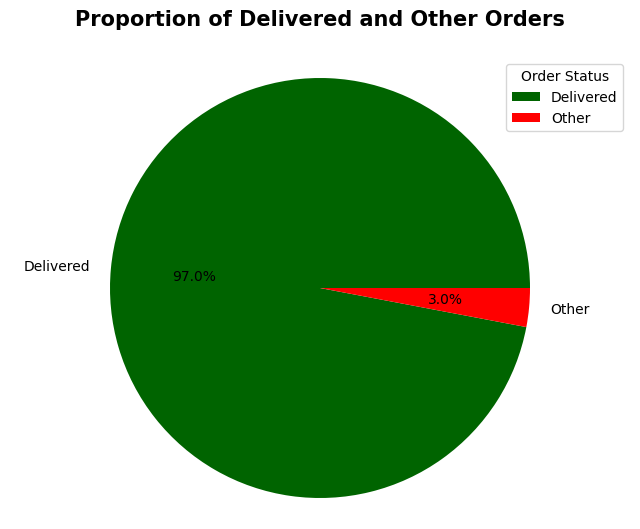

In [96]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
delivered_count = pd.read_sql("""
        SELECT COUNT(order_status)
        FROM orders
        WHERE order_status = 'delivered';
""", engine)

other_count = pd.read_sql("""
        SELECT COUNT(order_status)
        FROM orders
        WHERE order_status != 'delivered';
""", engine)
delivered_count = delivered_count['count'][0]
other_count = other_count['count'][0]
engine.dispose()

chart_data = pd.DataFrame({
    'Status': ['Delivered', 'Other'],
    'Count': [delivered_count, other_count]
})
plt.figure(figsize=(8, 6))
plt.pie(chart_data['Count'], labels=chart_data['Status'], autopct='%1.1f%%', startangle=0, colors = ['darkgreen', 'red'] )
plt.title('Proportion of Delivered and Other Orders\n', fontsize=15, fontweight='bold')

plt.legend(title='Order Status', loc='upper right', bbox_to_anchor=(1, 1))
plt.axis('equal')
plt.show()

In [97]:
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
del_time = pd.read_sql("""
    SELECT 
        ROUND(EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 3600) AS delivery_hours,
        EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / (3600 * 24) AS delivery_days
    FROM orders
    WHERE order_delivered_customer_date - order_purchase_timestamp IS NOT NULL;
""", engine)
engine.dispose()

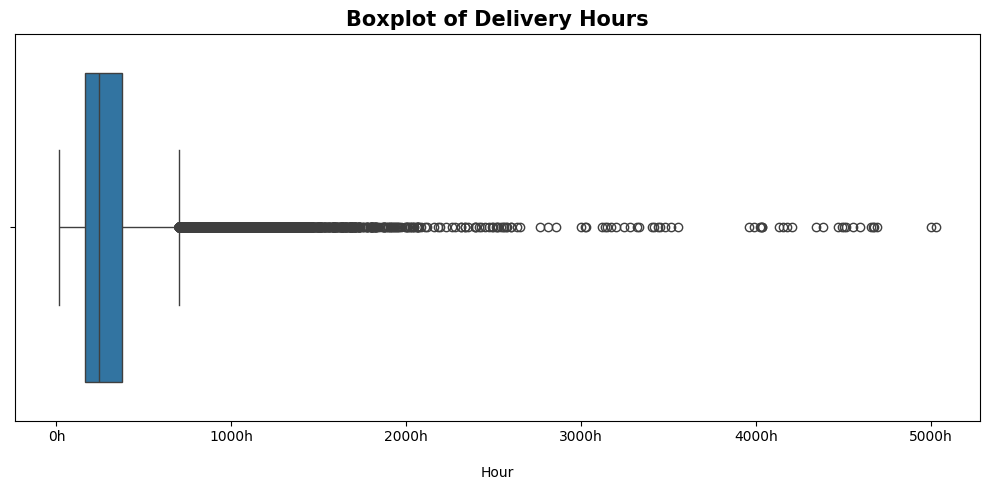

In [123]:
x = del_time["delivery_hours"]
plt.figure(figsize=(10, 5))
sns.boxplot(x=x, orient='h', showfliers=True)
plt.xlabel("\nHour")
plt.title("Boxplot of Delivery Hours", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0f}h"))
plt.tight_layout()
plt.show()

In [117]:
Q1 = del_time["delivery_hours"].quantile(0.25)
Q3 = del_time["delivery_hours"].quantile(0.75)
IQR = Q3 - Q1
fil_del_time = del_time[(del_time["delivery_hours"] >= Q1 - 1.5 * IQR) & (del_time["delivery_hours"] <= Q3 + 1.5 * IQR)]

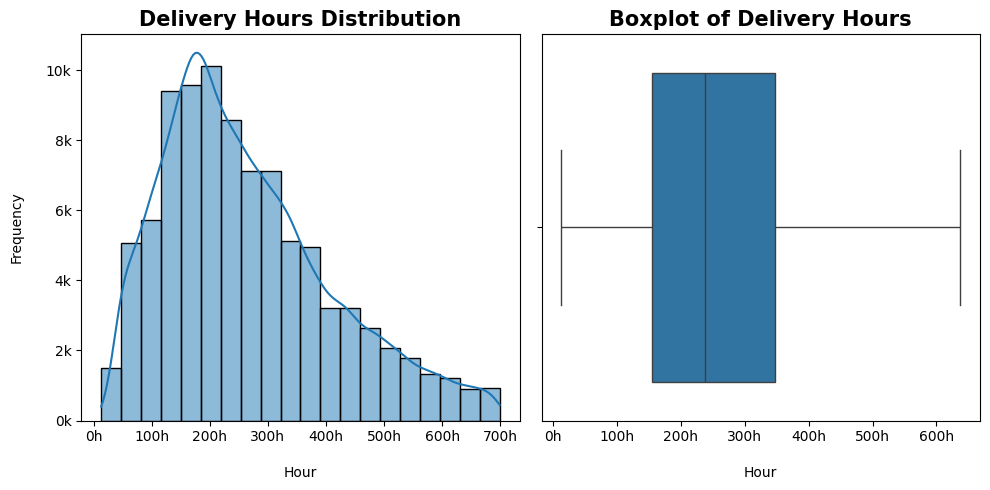

In [119]:
x = fil_del_time["delivery_hours"]
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(x=x, kde=True, bins=20)
plt.ylabel("Frequency\n")
plt.xlabel("\nHour")
plt.title("Delivery Hours Distribution", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0f}h"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x // 1000:,.0f}k"))

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=x, orient='h', showfliers=False)
plt.xlabel("\nHour")
plt.title("Boxplot of Delivery Hours", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0f}h"))


plt.tight_layout()
plt.show()

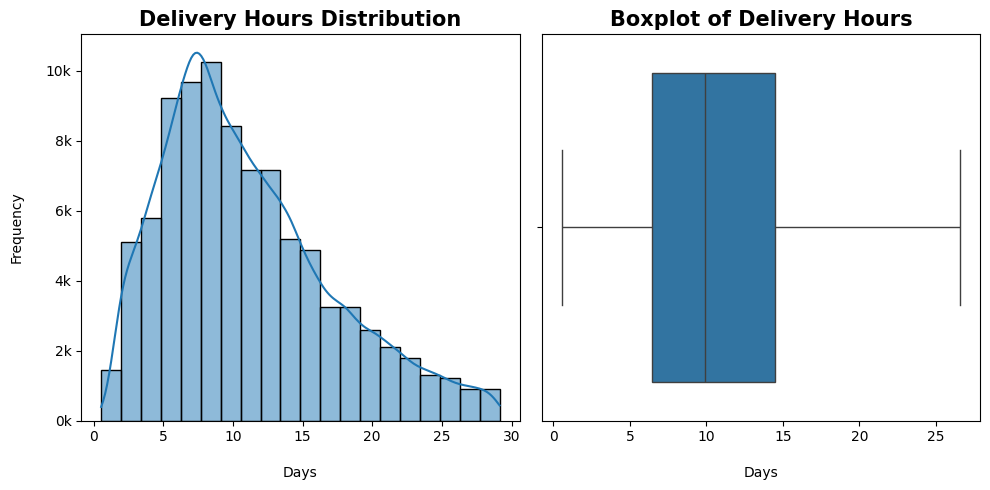

In [131]:
x = fil_del_time["delivery_days"]
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(x=x, kde=True, bins=20)
plt.ylabel("Frequency\n")
plt.xlabel("\nDays")
plt.title("Delivery Hours Distribution", fontsize=15, fontweight='bold')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x // 1000:,.0f}k"))

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=x, orient='h', showfliers=False)
plt.xlabel("\nDays")
plt.title("Boxplot of Delivery Hours", fontsize=15, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0f}"))


plt.tight_layout()
plt.show()

In [143]:
print(f"Min - {del_time['delivery_hours'].min()}h")
print(f"Max - {del_time['delivery_hours'].max()}h")
print(f"Median - {fil_del_time['delivery_hours'].median():.0f}h")
print(f"Mean - {fil_del_time['delivery_hours'].mean():.0f}h")
print(f"STD - {fil_del_time['delivery_hours'].std():.0f}h")

Min - 13.0h
Max - 5031.0h
Median - 238h
Mean - 265h
STD - 146h
